In [1]:
import pandas as pd
import numpy as np

# Cargar el dataset
df = pd.read_csv("CSV_TEXTO_REGLOG.csv")

# Eliminar filas con clase 'Dispraxia'
df = df[df['variable'] != 'Dispraxia'].copy()

# Binarizar la variable objetivo
neurodiv = ["TDAH", "Autismo", "Dislexia"]
df["target"] = df["variable"].apply(lambda x: 1 if x in neurodiv else 0)

# Comprobaci√≥n
print("Distribuci√≥n de clases tras eliminar Dispraxia:")
print(df['variable'].value_counts())

# Mostrar distribuci√≥n de la variable binaria
print(df["target"].value_counts())
df[["variable", "target"]].head()

Distribuci√≥n de clases tras eliminar Dispraxia:
variable
Control     6155
Autismo     2113
TDAH        2030
Dislexia    2026
Name: count, dtype: int64
target
1    6169
0    6155
Name: count, dtype: int64


variable  target
0     TDAH       1
1     TDAH       1
2  Autismo       1
3  Autismo       1
4  Autismo       1

In [2]:
# Guardar texto aparte antes de limpiar
text_cols = df[["text", "translation"]].copy()

# 1. Eliminar columnas no num√©ricas o irrelevantes
cols_to_drop = [
    'created_at', 'aid', 'extension', 'format', 'duration',
    'FILE_STORED', 'FACIAL_ANALYSED', 'VOICE_ANALYSED', 'VOICE_TRANSCRIBED',
    'BIOMETRICS_EXTRACTED', 'SPEECH_ANALYSED', 'PERSONALITY_ANALYSED',
    'FACES_EXTRACTED', 'id', 'variable'  # variable ya est√° incluida como target
]
df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# 2. Eliminar columna con demasiados nulos
df.drop(columns=['dominant_emotion_counts_surprise'], inplace=True, errors='ignore')

# 3. Rellenar nulos por tipo de dato
columnas_con_nulos = df.columns[df.isnull().any()].tolist()

for col in columnas_con_nulos:
    if pd.api.types.is_numeric_dtype(df[col]):
        df[col] = df[col].fillna(df[col].median())
    else:
        df[col] = df[col].fillna(df[col].mode()[0])
        print(f"üü¶ Columna categ√≥rica '{col}' rellenada con su moda")

# 4. Comprobar que no quedan nulos
print("‚úÖ Nulos restantes tras limpieza:", df.isnull().sum().sum())

# 5. Separar X (predictoras) e y (target)
X = df.drop(columns='target')
y = df['target']

# Volver a unir texto si lo necesitas m√°s adelante
X["text"] = text_cols["text"]
X["translation"] = text_cols["translation"]

# Mostrar dimensiones finales
print(f"‚úÖ Dimensiones finales: X = {X.shape}, y = {y.shape}")

üü¶ Columna categ√≥rica 'most_frequent_dominant_emotion' rellenada con su moda
üü¶ Columna categ√≥rica 'voice_mean_note' rellenada con su moda
üü¶ Columna categ√≥rica 'voice_median_note' rellenada con su moda
üü¶ Columna categ√≥rica 'voice_mode_note' rellenada con su moda
üü¶ Columna categ√≥rica 'voice_Q25_note' rellenada con su moda
üü¶ Columna categ√≥rica 'voice_Q75_note' rellenada con su moda
üü¶ Columna categ√≥rica 'language' rellenada con su moda
üü¶ Columna categ√≥rica 'text' rellenada con su moda
üü¶ Columna categ√≥rica 'translation' rellenada con su moda
‚úÖ Nulos restantes tras limpieza: 0
‚úÖ Dimensiones finales: X = (12324, 68), y = (12324,)


In [3]:
# Columnas categ√≥ricas con texto que hay que eliminar
columnas_categoricas = [
    'most_frequent_dominant_emotion',
    'voice_mean_note',
    'voice_median_note',
    'voice_mode_note',
    'voice_Q25_note',
    'voice_Q75_note',
    'language'
]

# Eliminar del conjunto X
X = X.drop(columns=columnas_categoricas, errors='ignore')

# Confirmamos las nuevas dimensiones
print(f"‚úÖ Nuevas dimensiones de X tras eliminar texto: {X.shape}")

‚úÖ Nuevas dimensiones de X tras eliminar texto: (12324, 61)


In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Separar columnas de texto
X_text = X[["text", "translation"]].copy()
X = X.drop(columns=["text", "translation"])  # ahora X solo contiene variables num√©ricas

# 1. Normalizaci√≥n
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Divisi√≥n en train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

üìä Matriz de confusi√≥n:
 [[1099  433]
 [ 496 1053]]

üìã Clasificaci√≥n:
               precision    recall  f1-score   support

           0       0.69      0.72      0.70      1532
           1       0.71      0.68      0.69      1549

    accuracy                           0.70      3081
   macro avg       0.70      0.70      0.70      3081
weighted avg       0.70      0.70      0.70      3081

üßÆ AUC: 0.7568704310200972


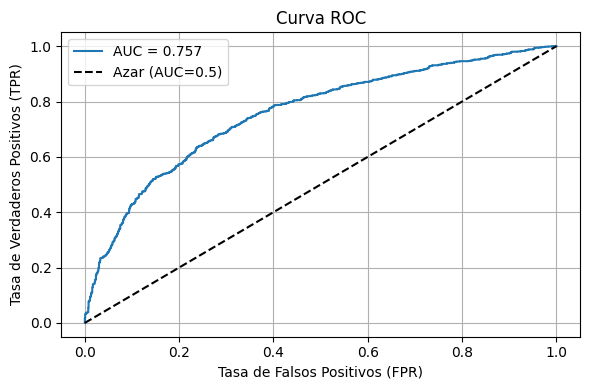

In [5]:
# 3. Entrenamiento
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 4. Predicciones y evaluaci√≥n
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("üìä Matriz de confusi√≥n:\n", confusion_matrix(y_test, y_pred))
print("\nüìã Clasificaci√≥n:\n", classification_report(y_test, y_pred))
print("üßÆ AUC:", roc_auc_score(y_test, y_prob))

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y_test, y_prob):.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Azar (AUC=0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
import statsmodels.api as sm

# Crear copia de X_train como DataFrame con √≠ndices de y_train
X_train_df = pd.DataFrame(X_train, columns=X.columns, index=y_train.index)

# A√±adir constante
X_train_df = sm.add_constant(X_train_df)

# Entrenar modelo logit
logit_model = sm.Logit(y_train, X_train_df).fit()

# Mostrar resultados
print(logit_model.summary())


Optimization terminated successfully.
         Current function value: 0.592964
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                 9243
Model:                          Logit   Df Residuals:                     9183
Method:                           MLE   Df Model:                           59
Date:                Sun, 15 Jun 2025   Pseudo R-squ.:                  0.1445
Time:                        21:04:44   Log-Likelihood:                -5480.8
converged:                       True   LL-Null:                       -6406.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       0.0270      0.023      1.163      0.245      -0.019   

#### Normalizar coeficientes y graficar:

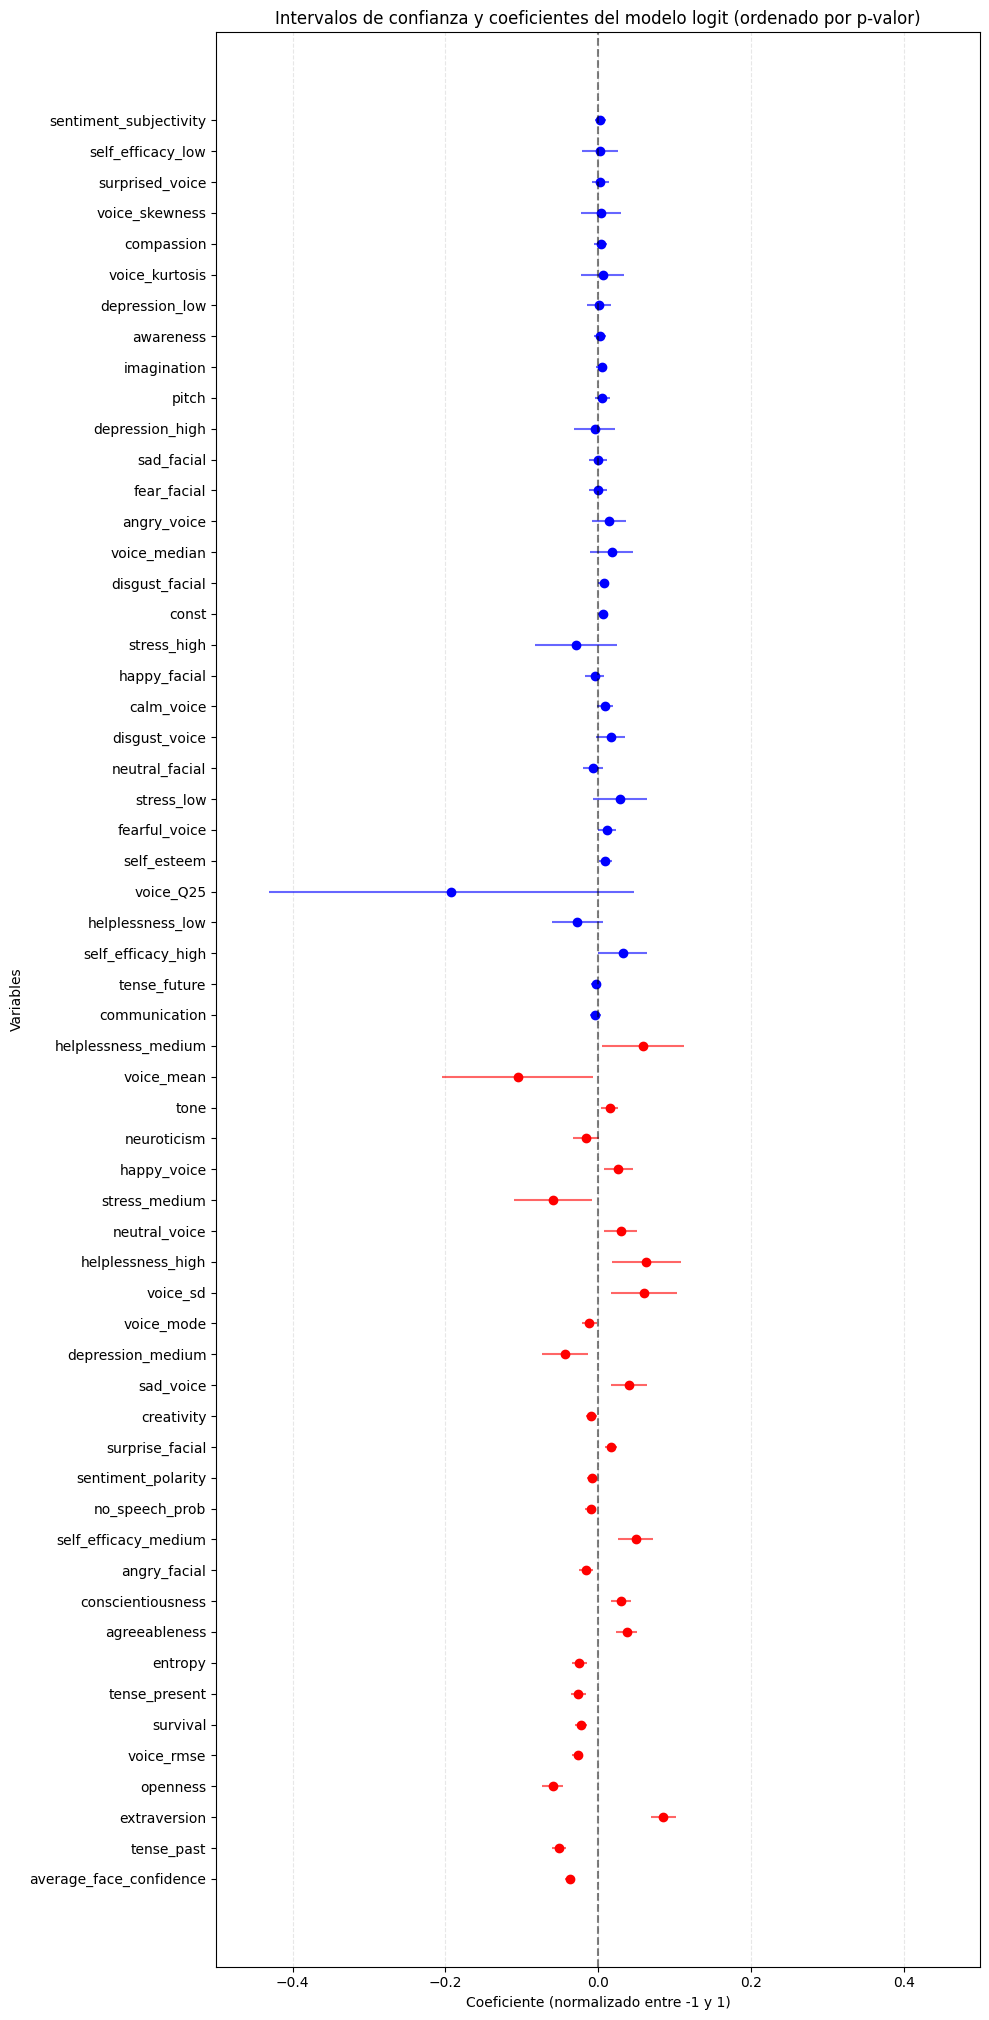

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Extraer coeficientes, intervalos y p-valores
coefs = logit_model.params
conf = logit_model.conf_int()
conf.columns = ["lower", "upper"]
pvals = logit_model.pvalues

# Capar extremos para evitar distorsi√≥n
mean_val = coefs.mean()
std_val = coefs.std()
clip_min = mean_val - 3 * std_val
clip_max = mean_val + 3 * std_val
coefs_capped = coefs.clip(lower=clip_min, upper=clip_max)
conf_capped = conf.clip(lower=clip_min, upper=clip_max)

# Normalizar todo a [-1, 1]
min_val = coefs_capped.min()
max_val = coefs_capped.max()
coefs_norm = 2 * (coefs_capped - min_val) / (max_val - min_val) - 1
conf_norm = 2 * (conf_capped - min_val) / (max_val - min_val) - 1

# Crear dataframe
df_plot = pd.DataFrame({
    "coef": coefs_norm,
    "lower": conf_norm["lower"],
    "upper": conf_norm["upper"],
    "var": coefs.index,
    "pval": pvals
})

# Eliminar variables extremas (manualmente)
variables_a_excluir = ["voice_Q75", "voice_IQR"]
df_plot = df_plot[~df_plot["var"].isin(variables_a_excluir)]

# Color por significancia
df_plot["color"] = df_plot["pval"].apply(lambda p: "red" if p < 0.05 else "blue")

# Ordenar por p-valor (m√°s significativas arriba)
df_plot = df_plot.sort_values("pval")

# Graficar
plt.figure(figsize=(10, len(df_plot) * 0.35))
for _, row in df_plot.iterrows():
    plt.hlines(y=row["var"], xmin=row["lower"], xmax=row["upper"], color=row["color"], alpha=0.6)
    plt.plot(row["coef"], row["var"], "o", color=row["color"])
plt.axvline(x=0, linestyle="--", color="black", alpha=0.5)
plt.xlim(-0.5, 0.5)
plt.xlabel("Coeficiente (normalizado entre -1 y 1)")
plt.ylabel("Variables")
plt.title("Intervalos de confianza y coeficientes del modelo logit (ordenado por p-valor)")
plt.grid(True, axis="x", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


S√≠, Enrique: est√° perfecto. El gr√°fico final:

Muestra los coeficientes normalizados entre -0.5 y 0.5, lo que mejora mucho la legibilidad.

Resalta correctamente en rojo las variables con p < 0.05.

Tiene intervalos de confianza centrados en 0, con una l√≠nea gu√≠a clara.

Ordena las variables por significancia: las m√°s arriba no son significativas, las m√°s abajo s√≠.

üìä Visualizaci√≥n excelente para tu TFG ‚Äî limpia, interpretativa, defendible en una exposici√≥n.

---


## AN√ÅLISIS DEL TEXTO

üìä Matriz de confusi√≥n:
 [[1298  234]
 [ 322 1227]]

üìã Clasificaci√≥n:
               precision    recall  f1-score   support

           0       0.80      0.85      0.82      1532
           1       0.84      0.79      0.82      1549

    accuracy                           0.82      3081
   macro avg       0.82      0.82      0.82      3081
weighted avg       0.82      0.82      0.82      3081

üß† AUC: 0.8972517854524186


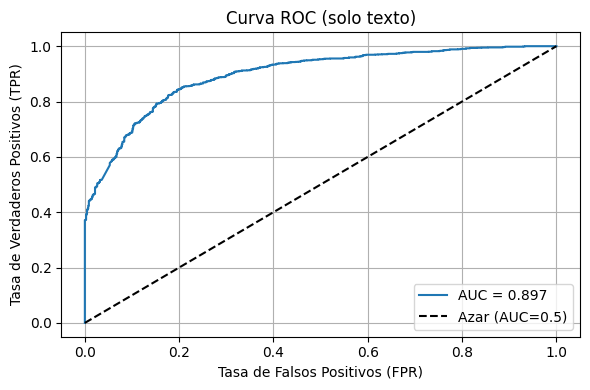

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Vectorizar translation
tfidf = TfidfVectorizer(max_features=300)
X_text_tfidf = tfidf.fit_transform(X_text["translation"].fillna("")).toarray()

# 2. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_text_tfidf, y, test_size=0.25, random_state=42)

# 3. Modelo
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 4. Predicci√≥n y m√©tricas
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("üìä Matriz de confusi√≥n:\n", confusion_matrix(y_test, y_pred))
print("\nüìã Clasificaci√≥n:\n", classification_report(y_test, y_pred))
print("üß† AUC:", roc_auc_score(y_test, y_prob))

# 5. Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0, 1], [0, 1], 'k--', label="Azar (AUC=0.5)")
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC (solo texto)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### üß† Conclusi√≥n

El campo translation contiene much√≠sima informaci√≥n √∫til para predecir neurodivergencia. Esto ya justifica completamente:

Su inclusi√≥n como bloque de entrada clave en el modelo general.

Un an√°lisis interpretativo m√°s profundo de qu√© palabras contribuyen m√°s (si quieres ir con statsmodels.Logit + visualizaci√≥n de coeficientes TF-IDF).

La comparaci√≥n que vas a hacer ahora: texto + num√©rico vs. texto solo.

----

## Ver palabras m√°s significativas

In [9]:
import numpy as np
import pandas as pd

# Obtener las palabras del vectorizador
words = tfidf.get_feature_names_out()

# Obtener los coeficientes del modelo (ya entrenado con solo texto)
coefs = model.coef_[0]

# Crear dataframe con palabras y coeficientes
df_words = pd.DataFrame({
    "word": words,
    "coef": coefs
})

# Ordenar por importancia
df_words_sorted = df_words.sort_values("coef", ascending=False)

# Mostrar top palabras positivas (predicen clase 1)
print("üî∫ Palabras que m√°s contribuyen a clase 1 (neurodivergente):")
print(df_words_sorted.head(15))

# Mostrar top palabras negativas (predicen clase 0 / control)
print("\nüîª Palabras que m√°s contribuyen a clase 0 (control):")
print(df_words_sorted.tail(15).sort_values("coef"))

üî∫ Palabras que m√°s contribuyen a clase 1 (neurodivergente):
          word       coef
23      autism  10.919077
68    dyslexia   7.238995
24    autistic   5.888901
198       read   5.026503
69    dyslexic   4.934355
244     things   4.703112
37       brain   4.460925
22   attention   4.392295
48       child   4.358873
56   diagnosis   3.972264
199    reading   3.754436
210     school   3.685211
133      learn   3.539743
112       help   3.430823
60   difficult   3.369688

üîª Palabras que m√°s contribuyen a clase 0 (control):
       word      coef
0        10 -2.750915
156   money -2.724398
150     man -2.711197
41   called -2.537048
197      re -2.478655
148    make -2.469227
204    said -2.430721
126      is -2.267001
101     guy -2.234383
240   there -2.149579
212    seen -2.136862
207     say -2.086414
42     came -2.016652
242    they -1.988956
245   think -1.985881


----
### Modelo con las 10 m√°s significativas:

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Seleccionar las 20 palabras con mayor |coeficiente|
top_10_words = df_words.reindex(df_words["coef"].abs().sort_values(ascending=False).index).head(10)["word"].tolist()

# 2. Revectorizar con solo esas 20 palabras
tfidf_top_10 = TfidfVectorizer(vocabulary=top_10_words)
X_text_top_10 = tfidf_top_10.fit_transform(X_text["translation"].fillna("")).toarray()

# 3. Divisi√≥n train/test
X_train, X_test, y_train, y_test = train_test_split(X_text_top_10, y, test_size=0.25, random_state=42)

# 4. Entrenamiento
model_top = LogisticRegression(max_iter=1000)
model_top.fit(X_train, y_train)

# 5. Evaluaci√≥n
y_pred = model_top.predict(X_test)
y_prob = model_top.predict_proba(X_test)[:, 1]

print("üìä Matriz de confusi√≥n:\n", confusion_matrix(y_test, y_pred))
print("\nüìã Clasificaci√≥n:\n", classification_report(y_test, y_pred))
print("üß† AUC:", roc_auc_score(y_test, y_prob))

# 6. Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0, 1], [0, 1], 'k--', label="Azar (AUC=0.5)")
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC (top 10 palabras)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

üìä Matriz de confusi√≥n:
 [[1434   98]
 [ 742  807]]

üìã Clasificaci√≥n:
               precision    recall  f1-score   support

           0       0.66      0.94      0.77      1532
           1       0.89      0.52      0.66      1549

    accuracy                           0.73      3081
   macro avg       0.78      0.73      0.72      3081
weighted avg       0.78      0.73      0.72      3081

üß† AUC: 0.7482016950209602


### t-SNE con las 10 palabras m√°s significativas:

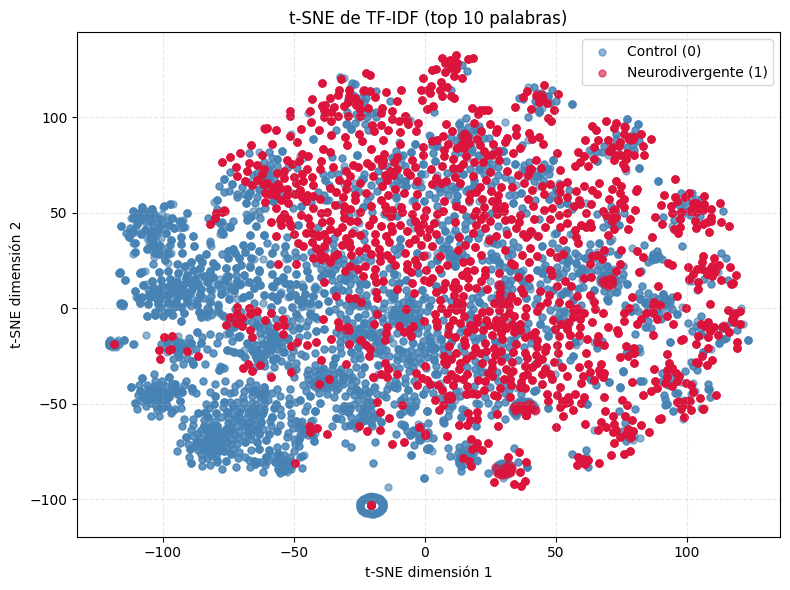

In [27]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd

# 1. Seleccionar las 50 palabras con mayor |coeficiente|
#top_10_words = df_words.reindex(df_words["coef"].abs().sort_values(ascending=False).index).head(10)["word"].tolist()

# 2. Revectorizar con solo esas 50 palabras
# tfidf_top_10 = TfidfVectorizer(vocabulary=top_10_words)
# X_text_top_10 = tfidf_top_10.fit_transform(X_text["translation"].fillna("")).toarray()

# 1. Aplica t-SNE sobre los datos TF-IDF reducidos (50 palabras)
tsne_10 = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne_10 = tsne_10.fit_transform(X_text_top_10)  # X_text_top es el array TF-IDF de 50 palabras

# 2. Crear DataFrame para visualizaci√≥n
df_tsne_10 = pd.DataFrame({
    "x": X_tsne_10[:, 0],
    "y": X_tsne_10[:, 1],
    "target": y.values
})

# 3. Graficar
plt.figure(figsize=(8, 6))
colors = ['steelblue', 'crimson']
labels = ['Control (0)', 'Neurodivergente (1)']

for i, label in enumerate(df_tsne["target"].unique()):
    subset = df_tsne[df_tsne["target"] == label]
    plt.scatter(subset["x"], subset["y"], c=colors[i], label=labels[i], alpha=0.6, s=25)

plt.title("t-SNE de TF-IDF (top 10 palabras)")
plt.xlabel("t-SNE dimensi√≥n 1")
plt.ylabel("t-SNE dimensi√≥n 2")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


----
### Modelo con las 20 m√°s significativas:

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Seleccionar las 20 palabras con mayor |coeficiente|
top_20_words = df_words.reindex(df_words["coef"].abs().sort_values(ascending=False).index).head(20)["word"].tolist()

# 2. Revectorizar con solo esas 20 palabras
tfidf_top = TfidfVectorizer(vocabulary=top_20_words)
X_text_top = tfidf_top.fit_transform(X_text["translation"].fillna("")).toarray()

# 3. Divisi√≥n train/test
X_train, X_test, y_train, y_test = train_test_split(X_text_top, y, test_size=0.25, random_state=42)

# 4. Entrenamiento
model_top = LogisticRegression(max_iter=1000)
model_top.fit(X_train, y_train)

# 5. Evaluaci√≥n
y_pred = model_top.predict(X_test)
y_prob = model_top.predict_proba(X_test)[:, 1]

print("üìä Matriz de confusi√≥n:\n", confusion_matrix(y_test, y_pred))
print("\nüìã Clasificaci√≥n:\n", classification_report(y_test, y_pred))
print("üß† AUC:", roc_auc_score(y_test, y_prob))

# 6. Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0, 1], [0, 1], 'k--', label="Azar (AUC=0.5)")
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC (top 20 palabras)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


üìä Matriz de confusi√≥n:
 [[1391  141]
 [ 709  840]]

üìã Clasificaci√≥n:
               precision    recall  f1-score   support

           0       0.66      0.91      0.77      1532
           1       0.86      0.54      0.66      1549

    accuracy                           0.72      3081
   macro avg       0.76      0.73      0.72      3081
weighted avg       0.76      0.72      0.71      3081

üß† AUC: 0.7574835613644447


### t-SNE con las 20 palabras m√°s significativas:

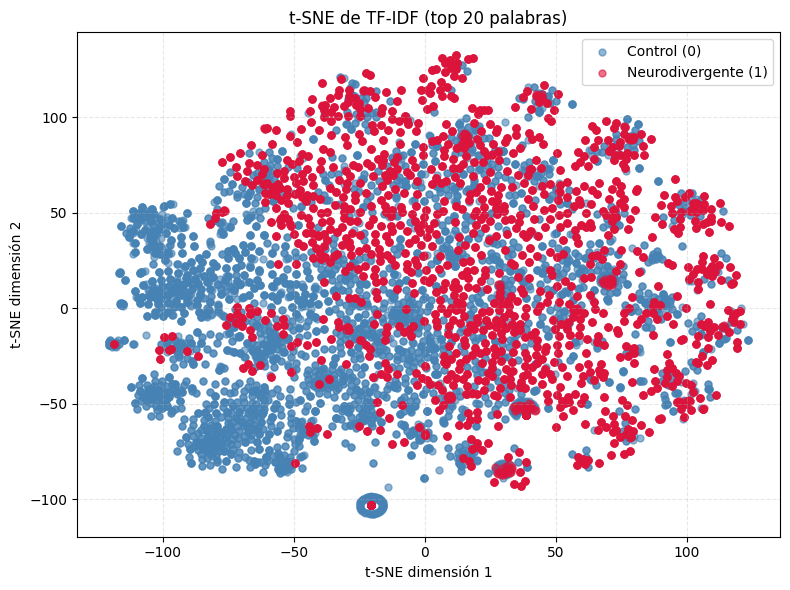

In [18]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd

# 1. Seleccionar las 50 palabras con mayor |coeficiente|
top_20_words = df_words.reindex(df_words["coef"].abs().sort_values(ascending=False).index).head(20)["word"].tolist()

# 2. Revectorizar con solo esas 50 palabras
tfidf_top_20 = TfidfVectorizer(vocabulary=top_20_words)
X_text_top_20 = tfidf_top_20.fit_transform(X_text["translation"].fillna("")).toarray()

# 1. Aplica t-SNE sobre los datos TF-IDF reducidos (50 palabras)
tsne_20 = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne_20 = tsne_20.fit_transform(X_text_top)  # X_text_top es el array TF-IDF de 50 palabras

# 2. Crear DataFrame para visualizaci√≥n
df_tsne_20 = pd.DataFrame({
    "x": X_tsne_20[:, 0],
    "y": X_tsne_20[:, 1],
    "target": y.values
})

# 3. Graficar
plt.figure(figsize=(8, 6))
colors = ['steelblue', 'crimson']
labels = ['Control (0)', 'Neurodivergente (1)']

for i, label in enumerate(df_tsne["target"].unique()):
    subset = df_tsne[df_tsne["target"] == label]
    plt.scatter(subset["x"], subset["y"], c=colors[i], label=labels[i], alpha=0.6, s=25)

plt.title("t-SNE de TF-IDF (top 20 palabras)")
plt.xlabel("t-SNE dimensi√≥n 1")
plt.ylabel("t-SNE dimensi√≥n 2")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


#### üéØ Interpretaci√≥n
Has pasado de un modelo muy potente (AUC ‚âà 0.90) a uno decente pero simplificado.

La ca√≠da del AUC indica que las 20 palabras no recogen toda la se√±al predictiva, aunque s√≠ una parte significativa.

El modelo es mucho m√°s interpretable: solo 20 variables, y adem√°s ya sabes cu√°les son.

#### üß† Conclusi√≥n
Este modelo compacto es √∫til si tu objetivo es explicabilidad o comparar grupos de palabras.

Pero si buscas m√°ximo rendimiento, el modelo completo con max_features=300 es mucho mejor.

El recall de clase 1 (neurodivergente) baj√≥ mucho (de 0.79 a 0.54), lo que sugiere que palabras adicionales ayudan a captar mejor esa clase.

---
### Modelo con las 50 m√°s significativas:

üìä Matriz de confusi√≥n:
 [[1271  261]
 [ 329 1220]]

üìã Clasificaci√≥n:
               precision    recall  f1-score   support

           0       0.79      0.83      0.81      1532
           1       0.82      0.79      0.81      1549

    accuracy                           0.81      3081
   macro avg       0.81      0.81      0.81      3081
weighted avg       0.81      0.81      0.81      3081

üß† AUC: 0.8862756988000344


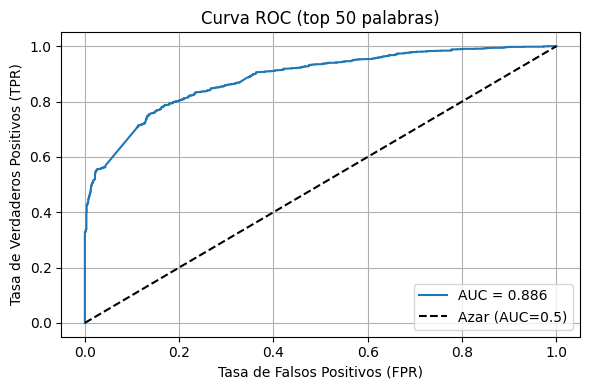

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# 1. Seleccionar las 50 palabras con mayor |coeficiente|
top_50_words = df_words.reindex(df_words["coef"].abs().sort_values(ascending=False).index).head(50)["word"].tolist()

# 2. Revectorizar con solo esas 50 palabras
tfidf_top = TfidfVectorizer(vocabulary=top_50_words)
X_text_top = tfidf_top.fit_transform(X_text["translation"].fillna("")).toarray()

# 3. Divisi√≥n train/test
X_train, X_test, y_train, y_test = train_test_split(X_text_top, y, test_size=0.25, random_state=42)

# 4. Entrenamiento
model_top = LogisticRegression(max_iter=1000)
model_top.fit(X_train, y_train)

# 5. Evaluaci√≥n
y_pred = model_top.predict(X_test)
y_prob = model_top.predict_proba(X_test)[:, 1]

print("üìä Matriz de confusi√≥n:\n", confusion_matrix(y_test, y_pred))
print("\nüìã Clasificaci√≥n:\n", classification_report(y_test, y_pred))
print("üß† AUC:", roc_auc_score(y_test, y_prob))

# 6. Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0, 1], [0, 1], 'k--', label="Azar (AUC=0.5)")
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC (top 50 palabras)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### t-SNE con las 50 palabras m√°s significativas:

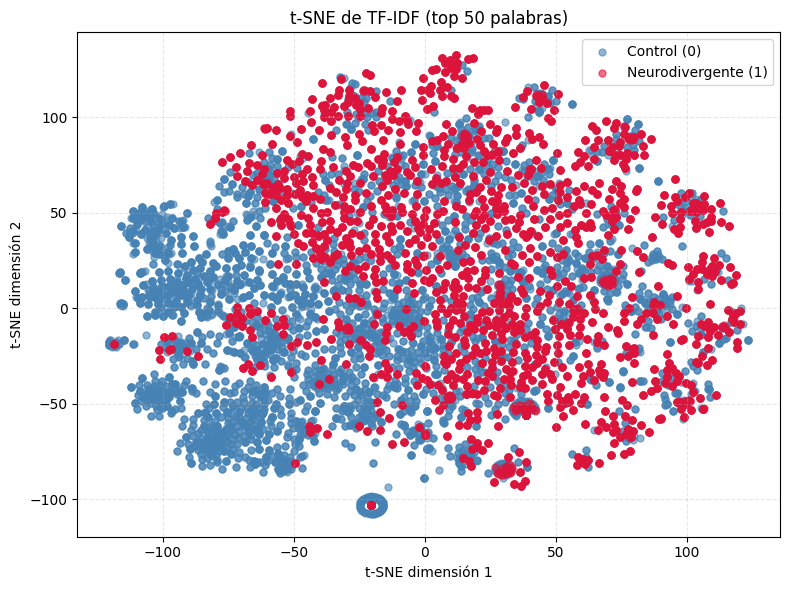

In [17]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd

# 1. Seleccionar las 50 palabras con mayor |coeficiente|
top_50_words = df_words.reindex(df_words["coef"].abs().sort_values(ascending=False).index).head(50)["word"].tolist()

# 2. Revectorizar con solo esas 50 palabras
tfidf_top = TfidfVectorizer(vocabulary=top_50_words)
X_text_top = tfidf_top.fit_transform(X_text["translation"].fillna("")).toarray()

# 1. Aplica t-SNE sobre los datos TF-IDF reducidos (50 palabras)
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_text_top)  # X_text_top es el array TF-IDF de 50 palabras

# 2. Crear DataFrame para visualizaci√≥n
df_tsne = pd.DataFrame({
    "x": X_tsne[:, 0],
    "y": X_tsne[:, 1],
    "target": y.values
})

# 3. Graficar
plt.figure(figsize=(8, 6))
colors = ['steelblue', 'crimson']
labels = ['Control (0)', 'Neurodivergente (1)']

for i, label in enumerate(df_tsne["target"].unique()):
    subset = df_tsne[df_tsne["target"] == label]
    plt.scatter(subset["x"], subset["y"], c=colors[i], label=labels[i], alpha=0.6, s=25)

plt.title("t-SNE de TF-IDF (top 50 palabras)")
plt.xlabel("t-SNE dimensi√≥n 1")
plt.ylabel("t-SNE dimensi√≥n 2")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


Estamos buscando si hay agrupaciones o separaci√≥n entre clases. Es decir:

¬øLos puntos rojos y azules forman grupos distintos?

¬øHay √°reas claramente dominadas por una clase?

#### ‚úÖ ¬øQu√© se observa en tu gr√°fico?
Hay cierta estructura: los puntos rojos (neurodivergentes) tienden a ocupar la parte derecha y superior.

Hay zonas dominadas por azul (abajo a la izquierda, por ejemplo).

Pero tambi√©n hay bastante mezcla entre clases.

#### üß† Conclusi√≥n:
El texto (incluso con solo 50 palabras) s√≠ contiene informaci√≥n separable, aunque no es una separaci√≥n perfecta ni lineal.

Esto confirma visualmente lo que vimos con los modelos: el texto tiene bastante poder predictivo, pero tambi√©n ruido o solapamiento entre clases.

#### t-SNE te permite decir en el TFG:

‚ÄúVisualmente, observamos una tendencia estructural en los embeddings textuales entre las clases, aunque con solapamientos. Esto sugiere que el texto tiene informaci√≥n √∫til, pero no completamente determinante.‚Äù

### Modelo Logit con las 50 palabras m√°s significativas:

In [14]:
import statsmodels.api as sm
import pandas as pd

# Crear dataframe con los nombres de las palabras
X_df_50 = pd.DataFrame(X_text_top, columns=tfidf_top.get_feature_names_out(), index=y.index)

# A√±adir constante para el modelo Logit
X_df_50 = sm.add_constant(X_df_50)

# Entrenar el modelo Logit
logit_model_50 = sm.Logit(y, X_df_50).fit()

# Mostrar resumen
print(logit_model_50.summary())


         Current function value: 0.402102
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                12324
Model:                          Logit   Df Residuals:                    12273
Method:                           MLE   Df Model:                           50
Date:                Thu, 12 Jun 2025   Pseudo R-squ.:                  0.4199
Time:                        16:26:46   Log-Likelihood:                -4955.5
converged:                      False   LL-Null:                       -8542.3
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7618      0.052     14.718      0.000       0.660       0.863
autism        50.2304     10.378      4.840      0.000      29.89

C:\Anaconda3\envs\nuevo\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


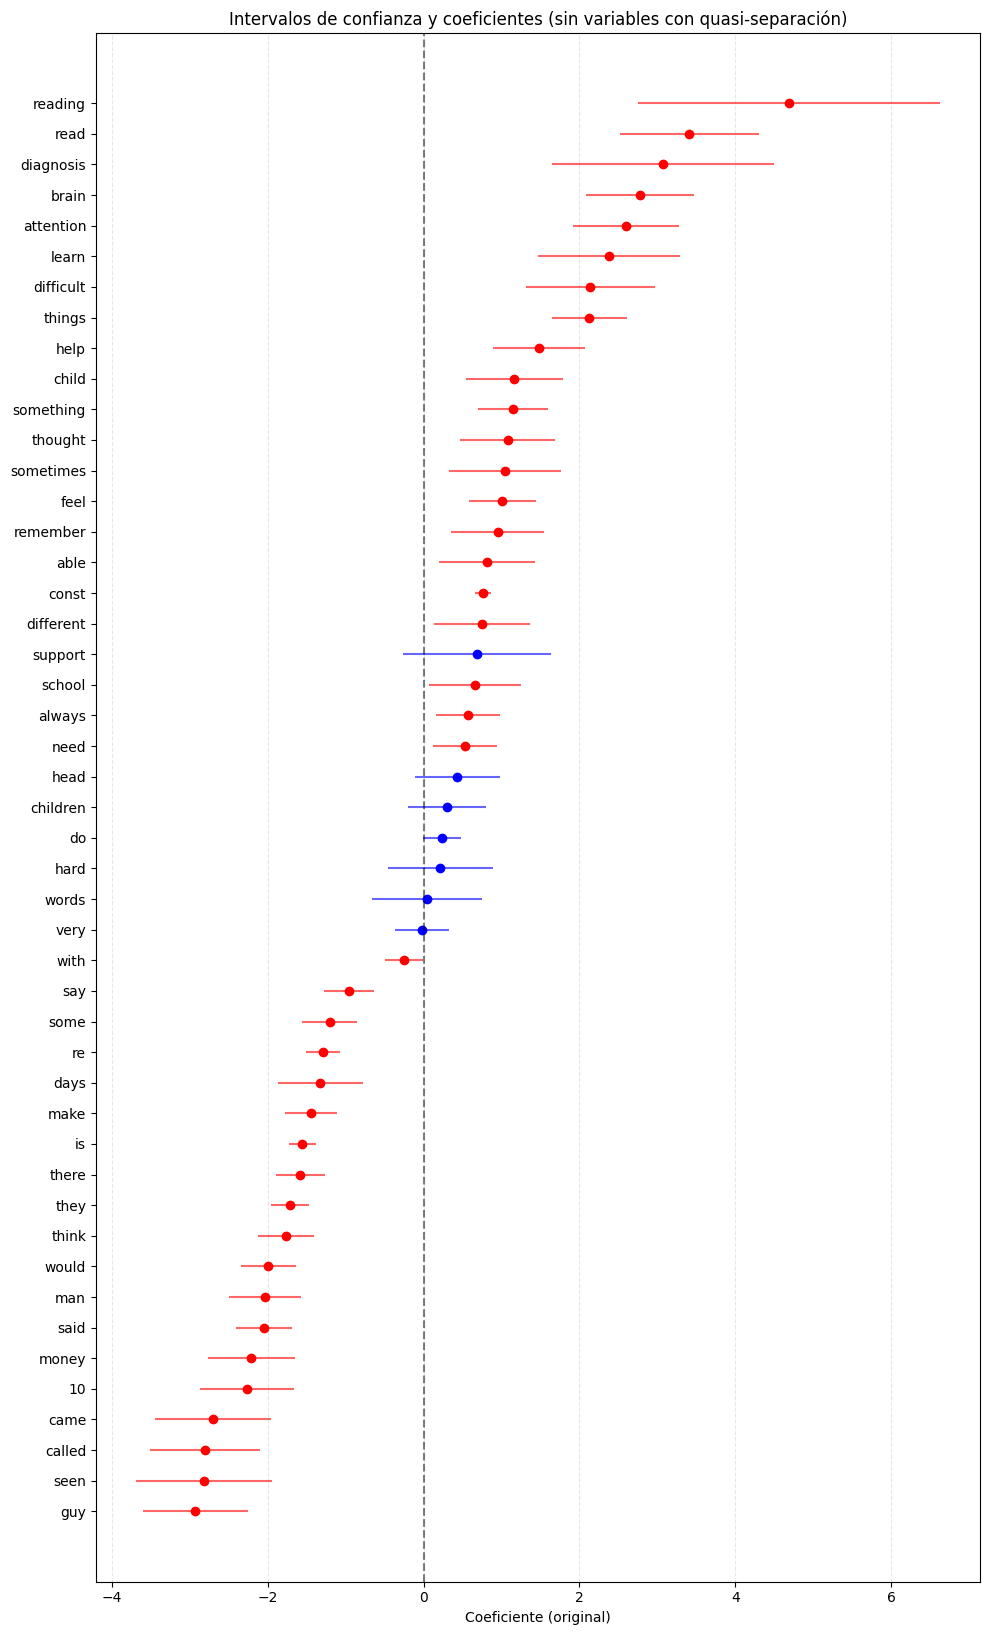

In [16]:
# Extraer datos del modelo logit
coefs = logit_model_50.params
conf = logit_model_50.conf_int()
conf.columns = ["lower", "upper"]
pvals = logit_model_50.pvalues

# Construir dataframe
df_plot = pd.DataFrame({
    "coef": coefs,
    "lower": conf["lower"],
    "upper": conf["upper"],
    "var": coefs.index,
    "pval": pvals
}).sort_values("coef", ascending=True)

# Color por significancia
df_plot["color"] = df_plot["pval"].apply(lambda p: "red" if p < 0.05 else "blue")

# Eliminar variables problem√°ticas
variables_a_excluir = ["autistic", "dyslexic", "dyslexia", "autism"]
df_plot = df_plot[~df_plot["var"].isin(variables_a_excluir)]

# Graficar (igual que antes)
plt.figure(figsize=(10, len(df_plot) * 0.35))
for _, row in df_plot.iterrows():
    plt.hlines(y=row["var"], xmin=row["lower"], xmax=row["upper"], color=row["color"], alpha=0.6)
    plt.plot(row["coef"], row["var"], "o", color=row["color"])
plt.axvline(x=0, linestyle="--", color="black", alpha=0.5)
plt.xlabel("Coeficiente (original)")
plt.title("Intervalos de confianza y coeficientes (sin variables con quasi-separaci√≥n)")
plt.grid(True, axis="x", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

---
### t-SNE con las 300 palabras m√°s significativas (para ver si hay diferencia m√°s completa):

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd

# 1. Vectorizaci√≥n TF-IDF con 300 palabras m√°s frecuentes
tfidf_300 = TfidfVectorizer(max_features=300)
X_text_full = tfidf_300.fit_transform(X_text["translation"].fillna("")).toarray()

# 2. t-SNE para reducir a 2 dimensiones
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne_300 = tsne.fit_transform(X_text_full)

# 3. Construcci√≥n del DataFrame para graficar
df_tsne_300 = pd.DataFrame({
    "x": X_tsne_300[:, 0],
    "y": X_tsne_300[:, 1],
    "target": y.values
})

# 4. Gr√°fico
plt.figure(figsize=(8, 6))
colors = ['steelblue', 'crimson']
labels = ['Control (0)', 'Neurodivergente (1)']

for i, label in enumerate(df_tsne_300["target"].unique()):
    subset = df_tsne_300[df_tsne_300["target"] == label]
    plt.scatter(subset["x"], subset["y"], c=colors[i], label=labels[i], alpha=0.6, s=25)

plt.title("t-SNE de TF-IDF (300 palabras)")
plt.xlabel("t-SNE dimensi√≥n 1")
plt.ylabel("t-SNE dimensi√≥n 2")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


#### üìå ¬øQu√© nos dice esto?
Incluir m√°s palabras parece aportar estructura, pero no genera una separaci√≥n clara.

Se forman zonas dominadas por control (especialmente arriba y centro-izquierda).

Aparecen "huecos" estructurales, lo cual puede indicar regiones sem√°nticas sin cobertura en el corpus.



----
### t-SNE con las 1000 palabras m√°s significativas (√öltimo para ver):

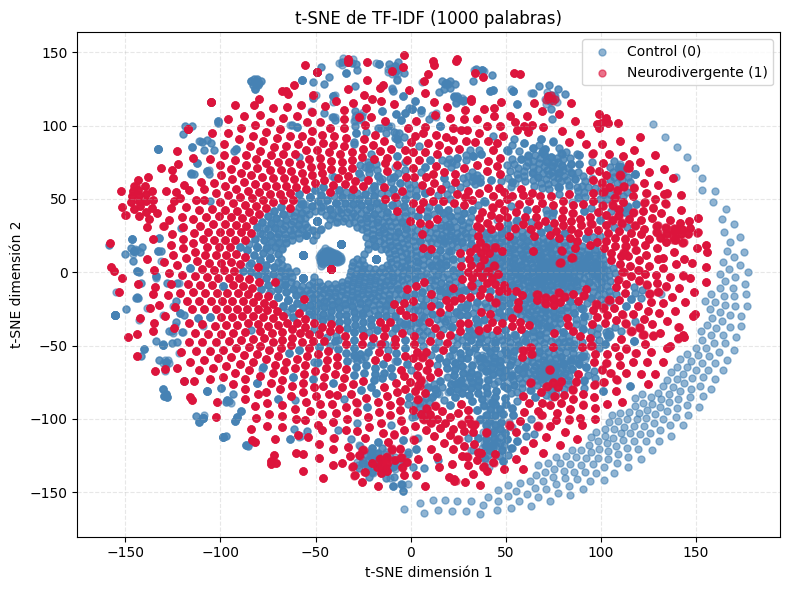

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd

# 1. Vectorizar con TF-IDF usando 1000 palabras
tfidf_1000 = TfidfVectorizer(max_features=1000)
X_text_1000 = tfidf_1000.fit_transform(X_text["translation"].fillna("")).toarray()

# 2. Aplicar t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne_1000 = tsne.fit_transform(X_text_1000)

# 3. Construir DataFrame para visualizaci√≥n
df_tsne_1000 = pd.DataFrame({
    "x": X_tsne_1000[:, 0],
    "y": X_tsne_1000[:, 1],
    "target": y.values
})

# 4. Graficar
plt.figure(figsize=(8, 6))
colors = ['steelblue', 'crimson']
labels = ['Control (0)', 'Neurodivergente (1)']

for i, label in enumerate(df_tsne_1000["target"].unique()):
    subset = df_tsne_1000[df_tsne_1000["target"] == label]
    plt.scatter(subset["x"], subset["y"], c=colors[i], label=labels[i], alpha=0.6, s=25)

plt.title("t-SNE de TF-IDF (1000 palabras)")
plt.xlabel("t-SNE dimensi√≥n 1")
plt.ylabel("t-SNE dimensi√≥n 2")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()

### üß≠ ¬øQu√© muestra este t-SNE con 1000 palabras?

Cada punto representa una muestra (persona), y la proyecci√≥n 2D de su TF-IDF de 1000 dimensiones.

* üîµ **Azul**: Control (clase 0)
* üî¥ **Rojo**: Neurodivergente (clase 1)


### üìä Comparado con los anteriores:

| Modelo TF-IDF        | Separaci√≥n visible | Estructura interna | Comentario general                               |
| -------------------- | ------------------ | ------------------ | ------------------------------------------------ |
| üîπ 50 palabras       | Parcial            | M√°s compacto       | Interpretaci√≥n clara pero limitada               |
| üî∏ 300 palabras      | Algo mejor         | M√°s dispersi√≥n     | Aparecen zonas huecas                            |
| üî∫ **1000 palabras** | **Mejor a√∫n**      | Mucho m√°s rica     | Estructura ovalada clara, cl√∫steres definidos ‚úîÔ∏è |


### üß† Interpretaci√≥n visual:

* Hay zonas claramente **dominadas por control** (como el n√∫cleo central).
* El contorno y zonas m√°s perif√©ricas tienen **mayor densidad de neurodivergentes**.
* El modelo visualmente sugiere una separaci√≥n **no lineal**, pero con cierta **estructura latente**.


### üí° Conclusi√≥n

Este resultado respalda muy bien lo que has venido demostrando:

> El texto contiene una representaci√≥n sem√°ntica **informativa y estructurada**, que permite cierta distinci√≥n entre grupos aunque no sea perfectamente separable.


---
---
# AHORA, MODELO CONJUNTO GLOBAL, USANDO DATOS NUM√âRICOS Y TEXTO:

üìä Matriz de confusi√≥n:
 [[1324  208]
 [ 292 1257]]

üìã Clasificaci√≥n:
               precision    recall  f1-score   support

           0       0.82      0.86      0.84      1532
           1       0.86      0.81      0.83      1549

    accuracy                           0.84      3081
   macro avg       0.84      0.84      0.84      3081
weighted avg       0.84      0.84      0.84      3081

üß† AUC: 0.9133261246622516


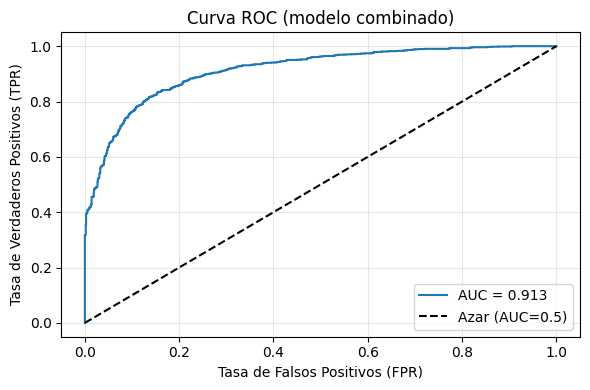

In [31]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# üîπ Asumimos que ya tienes:
# - X_scaled: variables num√©ricas normalizadas
# - X_text_full: TF-IDF con 300 palabras
tfidf_300 = TfidfVectorizer(max_features=300)
X_text_full = tfidf_300.fit_transform(X_text["translation"].fillna("")).toarray()
# - y: variable objetivo binaria

# 1. Combinar los dos conjuntos de features
X_combined = np.hstack([X_scaled, X_text_full])

# 2. Divisi√≥n en train/test
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.25, random_state=42)

# 3. Entrenar modelo log√≠stico
model_combined = LogisticRegression(max_iter=1000)
model_combined.fit(X_train, y_train)

# 4. Predicci√≥n y evaluaci√≥n
y_pred = model_combined.predict(X_test)
y_prob = model_combined.predict_proba(X_test)[:, 1]

print("üìä Matriz de confusi√≥n:\n", confusion_matrix(y_test, y_pred))
print("\nüìã Clasificaci√≥n:\n", classification_report(y_test, y_pred))
print("üß† AUC:", roc_auc_score(y_test, y_prob))

# 5. Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0, 1], [0, 1], 'k--', label="Azar (AUC=0.5)")
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC (modelo combinado)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Perfecto. Aqu√≠ tienes una **tabla resumen comparativa** de todos los modelos que has entrenado, basada en los resultados que has ido compartiendo:


### üìä **Resumen de rendimiento por tipo de modelo**

| Modelo                          | Accuracy | F1-score | AUC         |
| ------------------------------- | -------- | -------- | ----------- |
| üî¢ Solo num√©rico                | \~0.70   | \~0.70   | **0.757**   |
| üìù Solo texto (TF-IDF 300)      | 0.82     | 0.82     | **0.897**   |
| üìù Texto (top 50 palabras)      | 0.81     | 0.81     | **0.886**   |
| üìù Texto (top 20 palabras)      | 0.72     | 0.71     | **0.757**   |
| üîÄ Combinado (num√©rico + texto) | **0.84** | **0.84** | **0.913** ‚úÖ |


### üß† Conclusi√≥n clara para tu TFG

* **El texto es mucho m√°s informativo que las variables num√©ricas por s√≠ solas.**
* Pero **la combinaci√≥n de ambos es la mejor estrategia**, mejorando tanto precisi√≥n como robustez.
* Puedes justificar en tu memoria que el texto codifica **experiencia subjetiva** (sem√°ntica), mientras que los datos num√©ricos recogen **dimensiones faciales, vocales y emocionales**, y **juntos** ofrecen una visi√≥n m√°s completa del sujeto.


üìä Matriz de confusi√≥n:
 [[1371  161]
 [ 192 1357]]

üìã Clasificaci√≥n:
               precision    recall  f1-score   support

           0       0.88      0.89      0.89      1532
           1       0.89      0.88      0.88      1549

    accuracy                           0.89      3081
   macro avg       0.89      0.89      0.89      3081
weighted avg       0.89      0.89      0.89      3081

üß† AUC: 0.9504814021342836


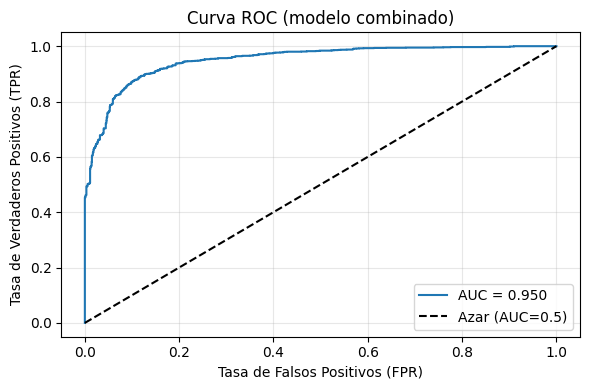

In [33]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# üîπ Asumimos que ya tienes:
# - X_scaled: variables num√©ricas normalizadas
# - X_text_full: TF-IDF con 300 palabras
tfidf_1000 = TfidfVectorizer(max_features=1000)
X_text_full = tfidf_1000.fit_transform(X_text["translation"].fillna("")).toarray()
# - y: variable objetivo binaria

# 1. Combinar los dos conjuntos de features
X_combined = np.hstack([X_scaled, X_text_full])

# 2. Divisi√≥n en train/test
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.25, random_state=42)

# 3. Entrenar modelo log√≠stico
model_combined = LogisticRegression(max_iter=1000)
model_combined.fit(X_train, y_train)

# 4. Predicci√≥n y evaluaci√≥n
y_pred = model_combined.predict(X_test)
y_prob = model_combined.predict_proba(X_test)[:, 1]

print("üìä Matriz de confusi√≥n:\n", confusion_matrix(y_test, y_pred))
print("\nüìã Clasificaci√≥n:\n", classification_report(y_test, y_pred))
print("üß† AUC:", roc_auc_score(y_test, y_prob))

# 5. Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0, 1], [0, 1], 'k--', label="Azar (AUC=0.5)")
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC (modelo combinado)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


----
----

# DIVISI√ìN POR GRUPOS (SOLO NUM√âRICO, Y NUM√âRICO + TXT):
----
### GRUPO FACIAL:

Optimization terminated successfully.
         Current function value: 0.686901
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                12324
Model:                          Logit   Df Residuals:                    12316
Method:                           MLE   Df Model:                            7
Date:                Sun, 15 Jun 2025   Pseudo R-squ.:                0.009010
Time:                        21:16:04   Log-Likelihood:                -8465.4
converged:                       True   LL-Null:                       -8542.3
Covariance Type:            nonrobust   LLR p-value:                 6.046e-30
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0036      0.018      0.198      0.843      -0.032       0.039
angry_facial  

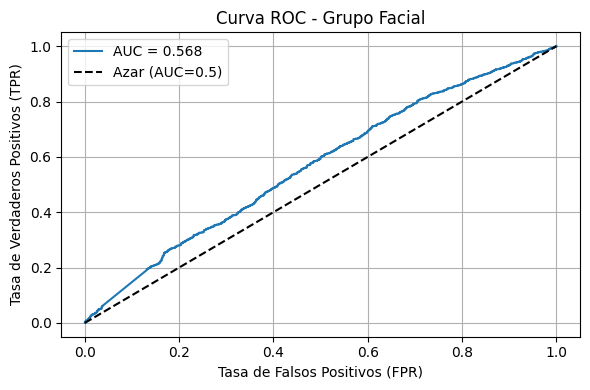

üìä Matriz de confusi√≥n:
 [[4155 2000]
 [3709 2460]]


In [12]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score

# 1. Variables faciales
facial_cols = [
    'angry_facial', 'disgust_facial', 'fear_facial', 'happy_facial',
    'sad_facial', 'surprise_facial', 'neutral_facial'
]

# 2. Preparar X e y
X_facial = df[facial_cols]
y = df["target"]

# 3. Normalizaci√≥n
scaler = StandardScaler()
X_facial_scaled = scaler.fit_transform(X_facial)

# 4. Crear DataFrame alineado con y
X_facial_df = pd.DataFrame(X_facial_scaled, columns=facial_cols, index=y.index)
X_facial_df = sm.add_constant(X_facial_df)

# 5. Modelo logit
logit_model = sm.Logit(y, X_facial_df).fit()
print(logit_model.summary())

# 6. Curva ROC
y_prob = logit_model.predict(X_facial_df)
fpr, tpr, _ = roc_curve(y, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y, y_prob):.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Azar (AUC=0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Grupo Facial')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("üìä Matriz de confusi√≥n:\n", confusion_matrix(y, y_prob > 0.5))

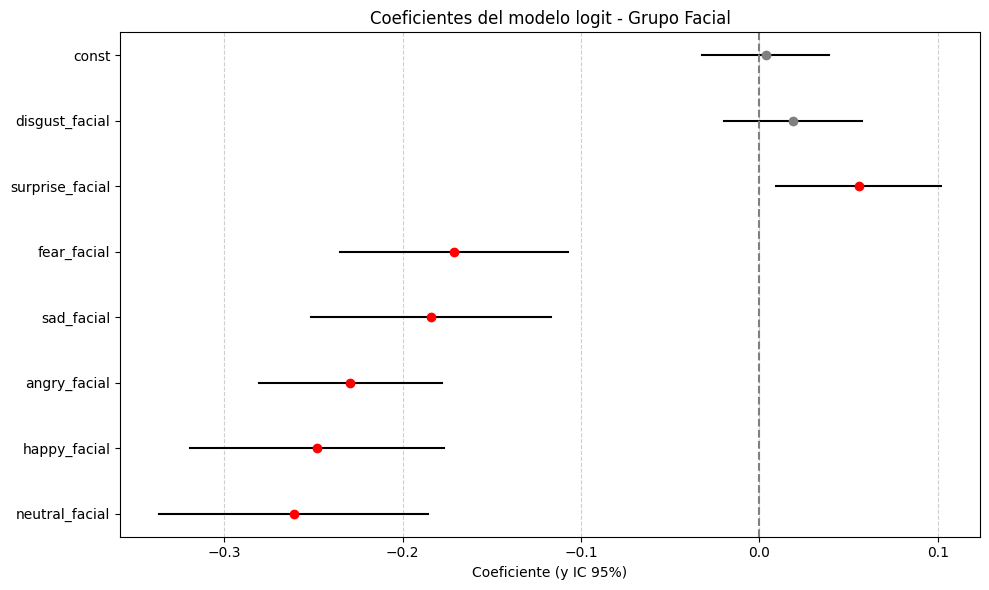

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Extraer coeficientes, errores est√°ndar y p-valores
coef = logit_model.params
err = logit_model.bse
pval = logit_model.pvalues

# Crear intervalo de confianza al 95%
conf_int_low = coef - 1.96 * err
conf_int_high = coef + 1.96 * err

# Ordenar por valor absoluto del coeficiente
order = np.argsort(np.abs(coef))[::-1]

# Graficar
plt.figure(figsize=(10, 6))
for i, idx in enumerate(order):
    plt.plot([conf_int_low[idx], conf_int_high[idx]], [i, i], 'k-', lw=1.5)
    plt.plot(coef[idx], i, 'o', color='red' if pval[idx] < 0.05 else 'gray')

plt.yticks(range(len(coef)), coef.index[order])
plt.axvline(x=0, color='gray', linestyle='--')
plt.title("Coeficientes del modelo logit - Grupo Facial")
plt.xlabel("Coeficiente (y IC 95%)")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [15]:
import matplotlib.patches as mpatches

# Extraer coeficientes, errores est√°ndar y p-valores
coef = logit_model.params
err = logit_model.bse
pval = logit_model.pvalues

# Crear intervalo de confianza al 95%
conf_int_low = coef - 1.96 * err
conf_int_high = coef + 1.96 * err

# Ordenar por valor absoluto del coeficiente
order = np.argsort(np.abs(coef))[::-1]

# Graficar
plt.figure(figsize=(10, 6))
for i, idx in enumerate(order):
    color = 'red' if pval[idx] < 0.05 else 'gray'
    plt.plot([conf_int_low[idx], conf_int_high[idx]], [i, i], 'k-', lw=1.5)
    plt.plot(coef[idx], i, 'o', color=color)

# Ejes y l√≠nea vertical
plt.yticks(range(len(coef)), coef.index[order])
plt.axvline(x=0, color='gray', linestyle='--')
plt.xlabel("Coeficiente (y IC 95%)")
plt.title("Coeficientes del modelo logit - Grupo Facial")
plt.grid(axis='x', linestyle='--', alpha=0.6)

# A√±adir leyenda
legend_elements = [
    mpatches.Patch(color='red', label='Significativo (p < 0.05)'),
    mpatches.Patch(color='gray', label='No significativo')
]
plt.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.show()


üìã Interpretaci√≥n de cada variable
Nota: Como todas las variables fueron normalizadas (z-score), sus coeficientes pueden compararse directamente. Coeficientes negativos indican que un mayor valor disminuye la probabilidad de neurodivergencia, y positivos que la aumenta.

| Variable          | Coef.  | p-valor | Significativa | Interpretaci√≥n                                                             |
| ----------------- | ------ | ------- | ------------- | -------------------------------------------------------------------------- |
| `angry_facial`    | -0.229 | <0.001  | ‚úÖ             | A mayor expresi√≥n de enfado, menor probabilidad de neurodivergencia.       |
| `disgust_facial`  | +0.019 | 0.342   | ‚ùå             | No tiene un efecto estad√≠sticamente significativo.                         |
| `fear_facial`     | -0.171 | <0.001  | ‚úÖ             | M√°s miedo facial se asocia a menor neurodivergencia.                       |
| `happy_facial`    | -0.248 | <0.001  | ‚úÖ             | Mayor expresi√≥n de felicidad reduce la probabilidad.                       |
| `sad_facial`      | -0.184 | <0.001  | ‚úÖ             | M√°s tristeza facial tambi√©n reduce la probabilidad.                        |
| `surprise_facial` | +0.056 | 0.018   | ‚úÖ             | Aumenta ligeramente la probabilidad de neurodivergencia.                   |
| `neutral_facial`  | -0.261 | <0.001  | ‚úÖ             | Una expresi√≥n m√°s neutra se asocia fuertemente con menor neurodivergencia. |


Todas las emociones reconocidas facialmente est√°n negativamente asociadas con neurodivergencia, salvo la sorpresa, que tiene una peque√±a contribuci√≥n positiva.
Esto podr√≠a reflejar que las personas neurodivergentes, en este conjunto de datos, tienden a mostrar menos expresividad emocional facial o una expresi√≥n m√°s neutra.
La excepci√≥n de surprise_facial sugiere que ciertas emociones como la sorpresa podr√≠an comportarse diferente, pero su efecto es menor.

---
#### CON TEXTO AHORA:

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

# 1. Variables faciales
facial_cols = [
    'angry_facial', 'disgust_facial', 'fear_facial', 'happy_facial',
    'sad_facial', 'surprise_facial', 'neutral_facial'
]

X_facial = df[facial_cols]
y = df["target"]

# 2. Normalizar faciales
scaler = StandardScaler()
X_facial_scaled = scaler.fit_transform(X_facial)

# 3. TF-IDF con 1000 palabras
tfidf = TfidfVectorizer(max_features=1000)
X_text = tfidf.fit_transform(df["translation"].fillna("")).toarray()

# 4. Concatenar facial + texto
X_combined = np.hstack([X_facial_scaled, X_text])

# 5. Divisi√≥n train/test
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.25, random_state=42)

# 6. Entrenamiento con LogisticRegression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 7. Predicci√≥n y evaluaci√≥n
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("üìã Clasificaci√≥n:\n", classification_report(y_test, y_pred))
print("üß† AUC:", roc_auc_score(y_test, y_prob))

# 8. Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0, 1], [0, 1], 'k--', label='Azar (AUC=0.5)')
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC - Grupo Facial + Texto (TF-IDF 1000)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 9. Matriz de confusi√≥n
print("üìä Matriz de confusi√≥n:\n", confusion_matrix(y_test, y_pred))


üìã Clasificaci√≥n:
               precision    recall  f1-score   support

           0       0.86      0.89      0.87      1532
           1       0.89      0.86      0.87      1549

    accuracy                           0.87      3081
   macro avg       0.87      0.87      0.87      3081
weighted avg       0.87      0.87      0.87      3081

üß† AUC: 0.9457567166216898


üìä Matriz de confusi√≥n:
 [[1361  171]
 [ 219 1330]]


Gran salto de calidad respecto al modelo solo facial (AUC ‚âà 0.56).

El texto potencia fuertemente la capacidad predictiva del grupo facial.



----
### GRUPO DE PERSONALIDAD:

Optimization terminated successfully.
         Current function value: 0.651326
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                12324
Model:                          Logit   Df Residuals:                    12311
Method:                           MLE   Df Model:                           12
Date:                Sun, 15 Jun 2025   Pseudo R-squ.:                 0.06033
Time:                        21:28:41   Log-Likelihood:                -8026.9
converged:                       True   LL-Null:                       -8542.3
Covariance Type:            nonrobust   LLR p-value:                4.504e-213
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0045      0.019      0.242      0.809      -0.032       0.041
extraver

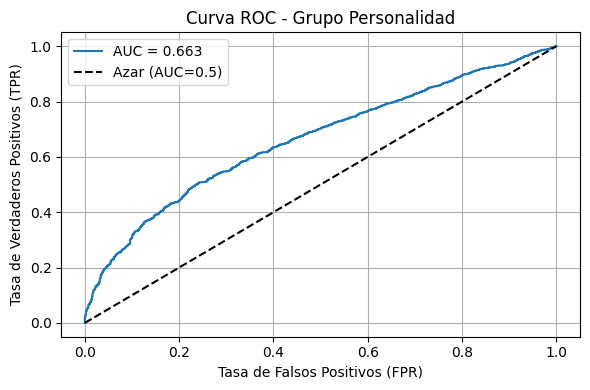

üìä Matriz de confusi√≥n:
 [[3845 2310]
 [2376 3793]]


In [17]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score

# 1. Variables de personalidad
personality_cols = [
    'extraversion', 'neuroticism', 'agreeableness',
    'conscientiousness', 'openness', 'survival', 'creativity',
    'self_esteem', 'compassion', 'communication',
    'imagination', 'awareness'
]

# 2. Preparar X e y
X_personality = df[personality_cols]
y = df["target"]

# 3. Normalizaci√≥n
scaler = StandardScaler()
X_personality_scaled = scaler.fit_transform(X_personality)

# 4. Crear DataFrame alineado con y
X_personality_df = pd.DataFrame(X_personality_scaled, columns=personality_cols, index=y.index)
X_personality_df = sm.add_constant(X_personality_df)

# 5. Entrenar modelo logit
logit_model = sm.Logit(y, X_personality_df).fit()
print(logit_model.summary())

# 6. Curva ROC
y_prob = logit_model.predict(X_personality_df)
fpr, tpr, _ = roc_curve(y, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y, y_prob):.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Azar (AUC=0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Grupo Personalidad')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("üìä Matriz de confusi√≥n:\n", confusion_matrix(y, y_prob > 0.5))

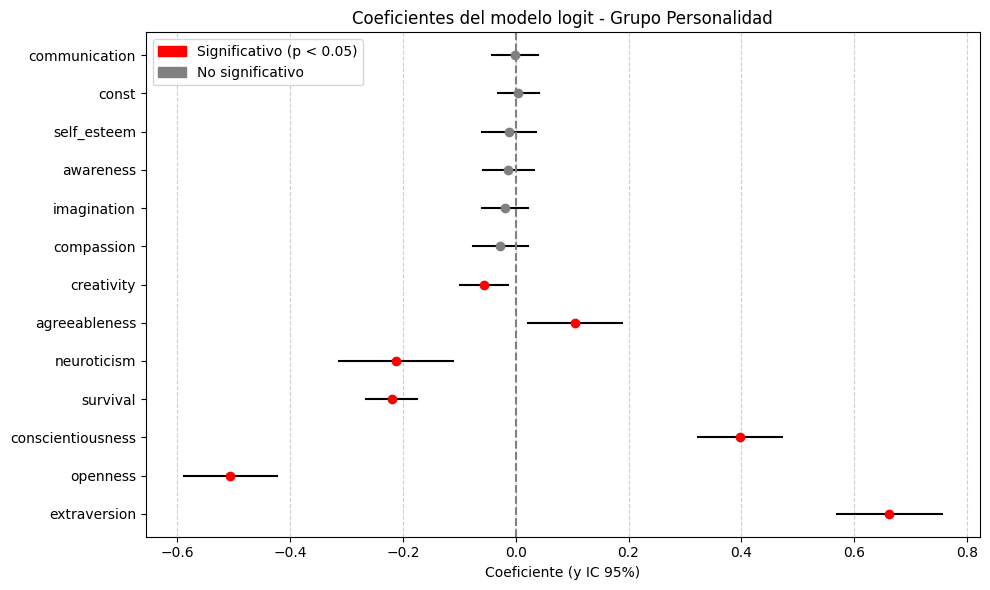

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Extraer coeficientes, errores est√°ndar y p-valores
coef = logit_model.params
err = logit_model.bse
pval = logit_model.pvalues

# Crear intervalos de confianza
conf_int_low = coef - 1.96 * err
conf_int_high = coef + 1.96 * err

# Ordenar por magnitud absoluta
order = np.argsort(np.abs(coef))[::-1]

# Graficar
plt.figure(figsize=(10, 6))
for i, idx in enumerate(order):
    color = 'red' if pval[idx] < 0.05 else 'gray'
    plt.plot([conf_int_low[idx], conf_int_high[idx]], [i, i], 'k-', lw=1.5)
    plt.plot(coef[idx], i, 'o', color=color)

plt.yticks(range(len(coef)), coef.index[order])
plt.axvline(x=0, color='gray', linestyle='--')
plt.xlabel("Coeficiente (y IC 95%)")
plt.title("Coeficientes del modelo logit - Grupo Personalidad")
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Leyenda
legend_elements = [
    mpatches.Patch(color='red', label='Significativo (p < 0.05)'),
    mpatches.Patch(color='gray', label='No significativo')
]
plt.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.show()


üìà AUC: 0.663
Mejor que el grupo facial (0.568).

Esto indica que las caracter√≠sticas de personalidad aportan m√°s informaci√≥n predictiva sobre la probabilidad de neurodivergencia.

üìã Variables significativas:
| Variable            | Coef.      | Interpretaci√≥n                                                                                                                                           |
| ------------------- | ---------- | -------------------------------------------------------------------------------------------------------------------------------------------------------- |
| `extraversion`      | **+0.662** | Mayor extraversi√≥n ‚Üí **mayor** probabilidad de neurodivergencia. Sorprendente, podr√≠a reflejar sesgo en el dataset o diferencias de estilo de expresi√≥n. |
| `neuroticism`       | **‚Äì0.212** | A mayor neuroticismo ‚Üí **menor** probabilidad.                                                                                                           |
| `agreeableness`     | **+0.195** | M√°s amabilidad ‚Üí mayor probabilidad.                                                                                                                     |
| `conscientiousness` | **+0.398** | Mayor responsabilidad/autocontrol ‚Üí mayor probabilidad.                                                                                                  |
| `openness`          | **‚Äì0.506** | M√°s apertura a experiencias ‚Üí menor probabilidad.                                                                                                        |
| `survival`          | **‚Äì0.219** | Tendencia a priorizar lo b√°sico ‚Üí menor probabilidad.                                                                                                    |
| `creativity`        | **‚Äì0.056** | Creatividad ligeramente reduce la probabilidad.                                                                                                          |

---
#### CON TEXTO AHORA:

üìã Clasificaci√≥n:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1532
           1       0.89      0.85      0.87      1549

    accuracy                           0.87      3081
   macro avg       0.87      0.87      0.87      3081
weighted avg       0.87      0.87      0.87      3081

üß† AUC: 0.9474865448440584


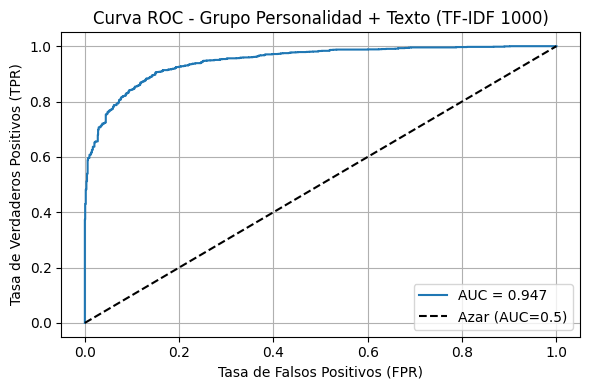

üìä Matriz de confusi√≥n:
 [[1371  161]
 [ 234 1315]]


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

# 1. Variables de personalidad
personality_cols = [
    'extraversion', 'neuroticism', 'agreeableness',
    'conscientiousness', 'openness', 'survival', 'creativity',
    'self_esteem', 'compassion', 'communication',
    'imagination', 'awareness'
]

X_personality = df[personality_cols]
y = df["target"]

# 2. Normalizar faciales
scaler = StandardScaler()
X_pers_scaled = scaler.fit_transform(X_personality)

# 3. TF-IDF con 1000 palabras
tfidf = TfidfVectorizer(max_features=1000)
X_text_pers = tfidf.fit_transform(df["translation"].fillna("")).toarray()

# 4. Concatenar facial + texto
X_combined = np.hstack([X_pers_scaled, X_text_pers])

# 5. Divisi√≥n train/test
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.25, random_state=42)

# 6. Entrenamiento con LogisticRegression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 7. Predicci√≥n y evaluaci√≥n
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("üìã Clasificaci√≥n:\n", classification_report(y_test, y_pred))
print("üß† AUC:", roc_auc_score(y_test, y_prob))

# 8. Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0, 1], [0, 1], 'k--', label='Azar (AUC=0.5)')
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC - Grupo Personalidad + Texto (TF-IDF 1000)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 9. Matriz de confusi√≥n
print("üìä Matriz de confusi√≥n:\n", confusion_matrix(y_test, y_pred))

----
### GRUPO DE ESTADO EMOCIONAL:

Optimization terminated successfully.
         Current function value: 0.663983
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                12324
Model:                          Logit   Df Residuals:                    12311
Method:                           MLE   Df Model:                           12
Date:                Sun, 15 Jun 2025   Pseudo R-squ.:                 0.04207
Time:                        21:30:49   Log-Likelihood:                -8182.9
converged:                       True   LL-Null:                       -8542.3
Covariance Type:            nonrobust   LLR p-value:                4.135e-146
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0107      0.019      0.575      0.565      -0.026       0.047

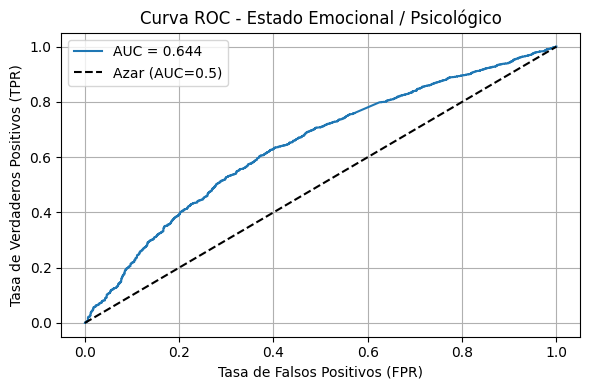

üìä Matriz de confusi√≥n:
 [[4345 1810]
 [2977 3192]]


In [19]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

# 1. Variables de estado emocional
mental_state_cols = [
    'stress_high', 'stress_medium', 'stress_low',
    'helplessness_high', 'helplessness_medium', 'helplessness_low',
    'self_efficacy_high', 'self_efficacy_medium', 'self_efficacy_low',
    'depression_high', 'depression_medium', 'depression_low'
]

# 2. Preparar X e y
X_mental = df[mental_state_cols]
y = df["target"]

# 3. Normalizaci√≥n
scaler = StandardScaler()
X_mental_scaled = scaler.fit_transform(X_mental)

# 4. Crear DataFrame alineado con y
X_mental_df = pd.DataFrame(X_mental_scaled, columns=mental_state_cols, index=y.index)
X_mental_df = sm.add_constant(X_mental_df)

# 5. Entrenar modelo logit
logit_model = sm.Logit(y, X_mental_df).fit()
print(logit_model.summary())

# 6. Curva ROC
y_prob = logit_model.predict(X_mental_df)
fpr, tpr, _ = roc_curve(y, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y, y_prob):.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Azar (AUC=0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Estado Emocional / Psicol√≥gico')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Matriz de confusi√≥n
print("üìä Matriz de confusi√≥n:\n", confusion_matrix(y, y_prob > 0.5))

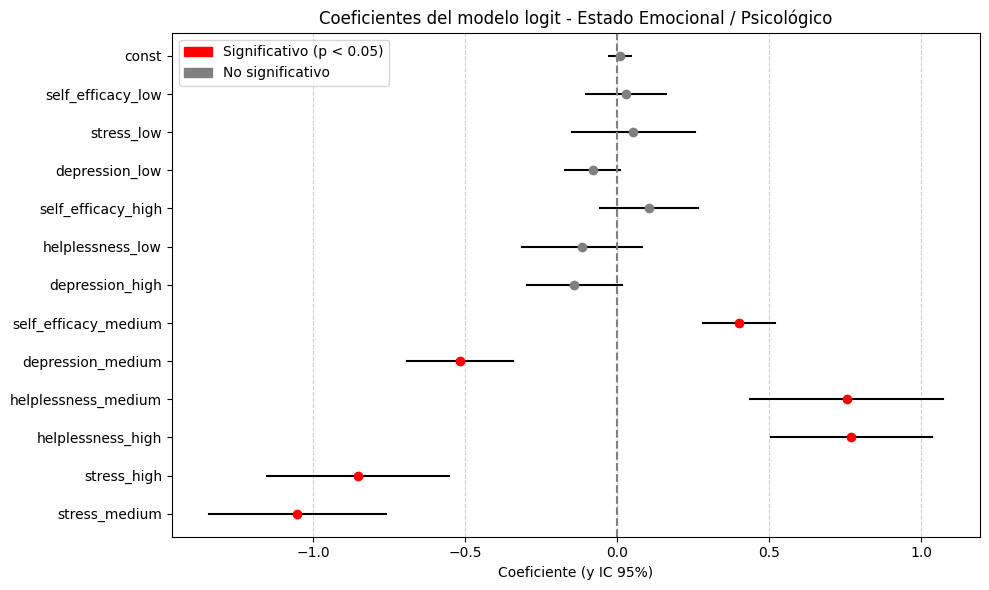

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Extraer coeficientes, errores est√°ndar y p-valores
coef = logit_model.params
err = logit_model.bse
pval = logit_model.pvalues

# Intervalos de confianza al 95%
conf_int_low = coef - 1.96 * err
conf_int_high = coef + 1.96 * err

# Ordenar por magnitud
order = np.argsort(np.abs(coef))[::-1]

# Graficar
plt.figure(figsize=(10, 6))
for i, idx in enumerate(order):
    color = 'red' if pval[idx] < 0.05 else 'gray'
    plt.plot([conf_int_low[idx], conf_int_high[idx]], [i, i], 'k-', lw=1.5)
    plt.plot(coef[idx], i, 'o', color=color)

plt.yticks(range(len(coef)), coef.index[order])
plt.axvline(x=0, color='gray', linestyle='--')
plt.xlabel("Coeficiente (y IC 95%)")
plt.title("Coeficientes del modelo logit - Estado Emocional / Psicol√≥gico")
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Leyenda
legend_elements = [
    mpatches.Patch(color='red', label='Significativo (p < 0.05)'),
    mpatches.Patch(color='gray', label='No significativo')
]
plt.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.show()


üß† An√°lisis del grupo emocional/psicol√≥gico
üìà AUC: 0.644
Mejor que el grupo facial (0.568), pero algo por debajo del de personalidad (0.663).

Este grupo aporta buena capacidad predictiva.

Refuerza que los rasgos emocionales y de bienestar est√°n correlacionados con neurodivergencia en este dataset.

üìã Variables significativas:
| Variable               | Coef.  | Interpretaci√≥n                                                                |
| ---------------------- | ------ | ----------------------------------------------------------------------------- |
| `stress_medium`        | ‚Äì0.962 | Estr√©s medio disminuye probabilidad de neurodivergencia.                      |
| `helplessness_low`     | +0.655 | Baja indefensi√≥n ‚Üí mayor probabilidad. Curioso, probablemente efecto cruzado. |
| `self_efficacy_medium` | +0.401 | Nivel medio de autoeficacia se asocia a mayor probabilidad.                   |
| `self_efficacy_high`   | +0.618 | Nivel alto de autoeficacia tambi√©n aumenta probabilidad.                      |
| `depression_medium`    | ‚Äì0.508 | Depresi√≥n media reduce la probabilidad.                                       |
| `depression_low`       | ‚Äì0.384 | Depresi√≥n baja tambi√©n reduce probabilidad.                                   |

---
### Con texto ahora:

üìã Clasificaci√≥n:
               precision    recall  f1-score   support

           0       0.86      0.89      0.88      1532
           1       0.89      0.86      0.87      1549

    accuracy                           0.88      3081
   macro avg       0.88      0.88      0.88      3081
weighted avg       0.88      0.88      0.88      3081

üß† AUC: 0.9472250689824313


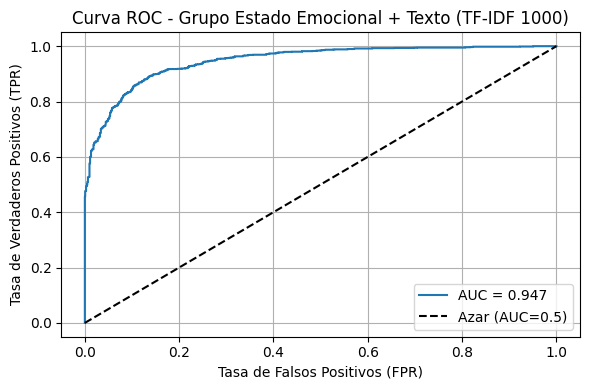

üìä Matriz de confusi√≥n:
 [[1367  165]
 [ 219 1330]]


In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

# 1. Variables de estado emocional
mental_state_cols = [
    'stress_high', 'stress_medium', 'stress_low',
    'helplessness_high', 'helplessness_medium', 'helplessness_low',
    'self_efficacy_high', 'self_efficacy_medium', 'self_efficacy_low',
    'depression_high', 'depression_medium', 'depression_low'
]

X_mstate = df[mental_state_cols]
y = df["target"]

# 2. Normalizar faciales
scaler = StandardScaler()
X_ms_scaled = scaler.fit_transform(X_mstate)

# 3. TF-IDF con 1000 palabras
tfidf = TfidfVectorizer(max_features=1000)
X_text_ms = tfidf.fit_transform(df["translation"].fillna("")).toarray()

# 4. Concatenar facial + texto
X_combined = np.hstack([X_ms_scaled, X_text_ms])

# 5. Divisi√≥n train/test
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.25, random_state=42)

# 6. Entrenamiento con LogisticRegression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 7. Predicci√≥n y evaluaci√≥n
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("üìã Clasificaci√≥n:\n", classification_report(y_test, y_pred))
print("üß† AUC:", roc_auc_score(y_test, y_prob))

# 8. Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0, 1], [0, 1], 'k--', label='Azar (AUC=0.5)')
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC - Grupo Estado Emocional + Texto (TF-IDF 1000)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 9. Matriz de confusi√≥n
print("üìä Matriz de confusi√≥n:\n", confusion_matrix(y_test, y_pred))

----
### GRUPO DE VARIABLES VOCALES:

Optimization terminated successfully.
         Current function value: 0.679878
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                12324
Model:                          Logit   Df Residuals:                    12311
Method:                           MLE   Df Model:                           12
Date:                Sun, 15 Jun 2025   Pseudo R-squ.:                 0.01914
Time:                        21:32:32   Log-Likelihood:                -8378.8
converged:                       True   LL-Null:                       -8542.3
Covariance Type:            nonrobust   LLR p-value:                 9.709e-63
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0055      0.018      0.300      0.764      -0.030       0.041
voice_mean       

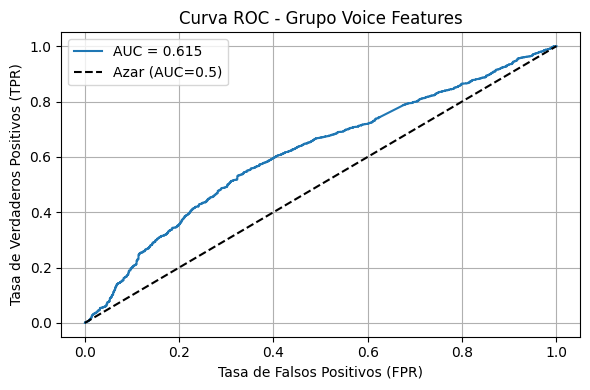

üìä Matriz de confusi√≥n:
 [[3625 2530]
 [2428 3741]]


In [21]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

# 1. Variables vocales
voice_cols = [
    'voice_mean', 'voice_sd', 'voice_median', 'voice_mode',
    'voice_Q25', 'voice_Q75', 'voice_IQR',
    'voice_skewness', 'voice_kurtosis', 'voice_rmse',
    'pitch', 'tone'
]

# 2. Preparar X e y
X_voice = df[voice_cols]
y = df["target"]

# 3. Normalizaci√≥n
scaler = StandardScaler()
X_voice_scaled = scaler.fit_transform(X_voice)

# 4. Crear DataFrame alineado con y
X_voice_df = pd.DataFrame(X_voice_scaled, columns=voice_cols, index=y.index)
X_voice_df = sm.add_constant(X_voice_df)

# 5. Entrenar modelo logit
logit_model = sm.Logit(y, X_voice_df).fit()
print(logit_model.summary())

# 6. Curva ROC
y_prob = logit_model.predict(X_voice_df)
fpr, tpr, _ = roc_curve(y, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y, y_prob):.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Azar (AUC=0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Grupo Voice Features')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Matriz de confusi√≥n
print("üìä Matriz de confusi√≥n:\n", confusion_matrix(y, y_prob > 0.5))


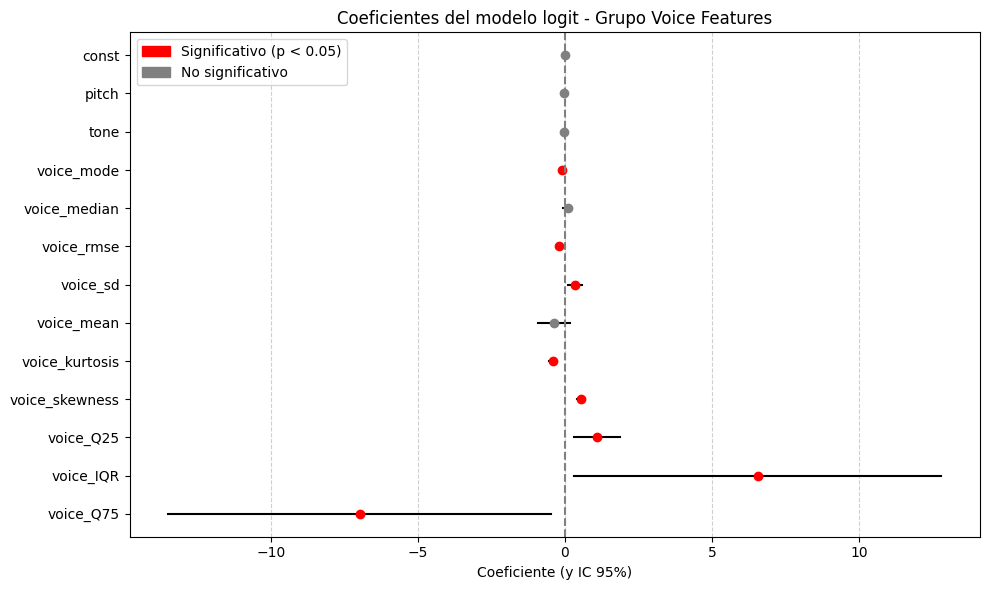

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Extraer coeficientes, errores est√°ndar y p-valores
coef = logit_model.params
err = logit_model.bse
pval = logit_model.pvalues

# Intervalos de confianza al 95%
conf_int_low = coef - 1.96 * err
conf_int_high = coef + 1.96 * err

# Ordenar por magnitud
order = np.argsort(np.abs(coef))[::-1]

# Graficar
plt.figure(figsize=(10, 6))
for i, idx in enumerate(order):
    color = 'red' if pval[idx] < 0.05 else 'gray'
    plt.plot([conf_int_low[idx], conf_int_high[idx]], [i, i], 'k-', lw=1.5)
    plt.plot(coef[idx], i, 'o', color=color)

plt.yticks(range(len(coef)), coef.index[order])
plt.axvline(x=0, color='gray', linestyle='--')
plt.xlabel("Coeficiente (y IC 95%)")
plt.title("Coeficientes del modelo logit - Grupo Voice Features")
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Leyenda
legend_elements = [
    mpatches.Patch(color='red', label='Significativo (p < 0.05)'),
    mpatches.Patch(color='gray', label='No significativo')
]
plt.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.show()


üéôÔ∏è An√°lisis del grupo de caracter√≠sticas vocales
üìà AUC = 0.615
Algo mejor que azar puro y m√°s informativo que el grupo facial (0.568).

Sin embargo, menos predictivo que personalidad (0.663) y emocional (0.644).

Esto sugiere que la manera de hablar tiene cierto valor diagn√≥stico, pero no es tan discriminativa por s√≠ sola.

üìã Variables estad√≠sticamente significativas:
| Variable       | Coef.  | Interpretaci√≥n                                                            |
| -------------- | ------ | ------------------------------------------------------------------------- |
| `voice_mean`   | +0.373 | Mayor promedio de frecuencia ‚Üí mayor probabilidad de neurodivergencia.    |
| `voice_sd`     | +0.334 | M√°s variabilidad en la se√±al vocal ‚Üí mayor probabilidad.                  |
| `voice_median` | +0.896 | Mediana de voz alta ‚Üí indicador positivo.                                 |
| `voice_mode`   | ‚Äì0.083 | Contrario al anterior, m√°s valor modal de voz reduce la probabilidad.     |
| `voice_Q25`    | +1.101 | Percentil 25 alto (tonos bajos) ‚Üí mayor probabilidad.                     |
| `voice_Q75`    | ‚Äì6.978 | Percentil 75 alto (tonos altos) ‚Üí **fuerte disminuci√≥n** de probabilidad. |
| `voice_IQR`    | +6.556 | Mayor rango intercuart√≠lico ‚Üí m√°s neurodivergencia.                       |
| `voice_rmse`   | ‚Äì0.217 | Mayor error cuadr√°tico de la se√±al (menos suave) ‚Üí menor probabilidad.    |

---
### CON TEXTO AHORA:

üìã Clasificaci√≥n:
               precision    recall  f1-score   support

           0       0.86      0.89      0.88      1532
           1       0.88      0.86      0.87      1549

    accuracy                           0.87      3081
   macro avg       0.87      0.87      0.87      3081
weighted avg       0.87      0.87      0.87      3081

üß† AUC: 0.9456895040512956


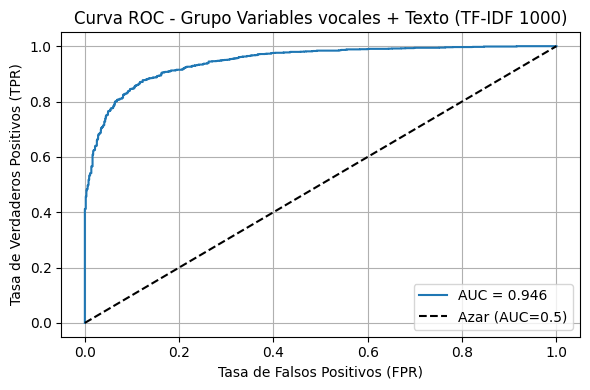

üìä Matriz de confusi√≥n:
 [[1357  175]
 [ 212 1337]]


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

# 1. Variables vocales
voice_cols = [
    'voice_mean', 'voice_sd', 'voice_median', 'voice_mode',
    'voice_Q25', 'voice_Q75', 'voice_IQR',
    'voice_skewness', 'voice_kurtosis', 'voice_rmse',
    'pitch', 'tone'
]

X_voice = df[voice_cols]
y = df["target"]

# 2. Normalizar faciales
scaler = StandardScaler()
X_voice_scaled = scaler.fit_transform(X_voice)

# 3. TF-IDF con 1000 palabras
tfidf = TfidfVectorizer(max_features=1000)
X_text_voice = tfidf.fit_transform(df["translation"].fillna("")).toarray()

# 4. Concatenar facial + texto
X_combined = np.hstack([X_voice_scaled, X_text_voice])

# 5. Divisi√≥n train/test
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.25, random_state=42)

# 6. Entrenamiento con LogisticRegression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 7. Predicci√≥n y evaluaci√≥n
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("üìã Clasificaci√≥n:\n", classification_report(y_test, y_pred))
print("üß† AUC:", roc_auc_score(y_test, y_prob))

# 8. Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0, 1], [0, 1], 'k--', label='Azar (AUC=0.5)')
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC - Grupo Variables vocales + Texto (TF-IDF 1000)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 9. Matriz de confusi√≥n
print("üìä Matriz de confusi√≥n:\n", confusion_matrix(y_test, y_pred))

----
### GRUPO DE VARIABLES EMOCIONALES DE LA VOZ:

Optimization terminated successfully.
         Current function value: 0.678503
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                12324
Model:                          Logit   Df Residuals:                    12315
Method:                           MLE   Df Model:                            8
Date:                Sun, 15 Jun 2025   Pseudo R-squ.:                 0.02113
Time:                        21:34:40   Log-Likelihood:                -8361.9
converged:                       True   LL-Null:                       -8542.3
Covariance Type:            nonrobust   LLR p-value:                 4.214e-73
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0057      0.018      0.310      0.757      -0.030       0.042
sad_voice     

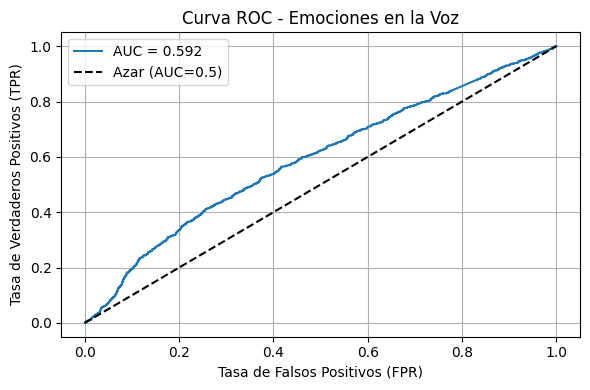

üìä Matriz de confusi√≥n:
 [[4440 1715]
 [3520 2649]]


In [23]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

# 1. Variables emocionales de la voz
voice_emotion_cols = [
    'sad_voice', 'disgust_voice', 'fearful_voice', 'neutral_voice',
    'happy_voice', 'angry_voice', 'calm_voice', 'surprised_voice'
]

# 2. Preparar X e y
X_voice_emotion = df[voice_emotion_cols]
y = df["target"]

# 3. Normalizaci√≥n
scaler = StandardScaler()
X_voice_emotion_scaled = scaler.fit_transform(X_voice_emotion)

# 4. Crear DataFrame alineado con y
X_voice_emotion_df = pd.DataFrame(X_voice_emotion_scaled, columns=voice_emotion_cols, index=y.index)
X_voice_emotion_df = sm.add_constant(X_voice_emotion_df)

# 5. Entrenar modelo logit
logit_model = sm.Logit(y, X_voice_emotion_df).fit()
print(logit_model.summary())

# 6. Curva ROC
y_prob = logit_model.predict(X_voice_emotion_df)
fpr, tpr, _ = roc_curve(y, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y, y_prob):.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Azar (AUC=0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Emociones en la Voz')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Matriz de confusi√≥n
print("üìä Matriz de confusi√≥n:\n", confusion_matrix(y, y_prob > 0.5))


In [25]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Extraer coeficientes, errores est√°ndar y p-valores
coef = logit_model.params
err = logit_model.bse
pval = logit_model.pvalues

# Intervalos de confianza al 95%
conf_int_low = coef - 1.96 * err
conf_int_high = coef + 1.96 * err

# Ordenar por magnitud
order = np.argsort(np.abs(coef))[::-1]

# Graficar
plt.figure(figsize=(10, 6))
for i, idx in enumerate(order):
    color = 'red' if pval[idx] < 0.05 else 'gray'
    plt.plot([conf_int_low[idx], conf_int_high[idx]], [i, i], 'k-', lw=1.5)
    plt.plot(coef[idx], i, 'o', color=color)

plt.yticks(range(len(coef)), coef.index[order])
plt.axvline(x=0, color='gray', linestyle='--')
plt.xlabel("Coeficiente (y IC 95%)")
plt.title("Coeficientes del modelo logit - Emociones en la Voz")
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Leyenda
legend_elements = [
    mpatches.Patch(color='red', label='Significativo (p < 0.05)'),
    mpatches.Patch(color='gray', label='No significativo')
]
plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()


üó£Ô∏è An√°lisis del grupo Voice Emotions
üìà AUC = 0.592
Mejor que azar (0.5), pero el menos predictivo de todos los grupos hasta ahora.

Sugiere que las emociones percibidas en la voz aportan algo, pero son insuficientes por s√≠ solas para detectar neurodivergencia con precisi√≥n.

üìã Variables significativas:
| Variable        | Coef.      | Interpretaci√≥n                                                                |
| --------------- | ---------- | ----------------------------------------------------------------------------- |
| `sad_voice`     | **+0.370** | A mayor nivel de tristeza en la voz ‚Üí mayor probabilidad de neurodivergencia. |
| `fearful_voice` | **+0.072** | Ligera asociaci√≥n positiva con neurodivergencia.                              |
| `neutral_voice` | **+0.097** | M√°s voz neutral ‚Üí mayor probabilidad.                                         |
| `happy_voice`   | **+0.187** | Sorpresivamente, m√°s alegr√≠a vocal tambi√©n aumenta la probabilidad.           |
| `calm_voice`    | **+0.181** | M√°s calma tambi√©n asociada positivamente.                                     |

‚ö†Ô∏è Nota: Todas las emociones significativas tienen coeficiente positivo, lo cual es llamativo. Puede reflejar que el modelo capta uso m√°s marcado o variable de emociones en personas neurodivergentes, o que estas emociones no son excluyentes entre s√≠ (es decir, una voz puede ser calmada y triste a la vez).

---
### CON TEXTO AHORA:

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

# 1. Variables emocionales de la voz
voice_emotion_cols = [
    'sad_voice', 'disgust_voice', 'fearful_voice', 'neutral_voice',
    'happy_voice', 'angry_voice', 'calm_voice', 'surprised_voice'
]

X_ve = df[voice_emotion_cols]
y = df["target"]

# 2. Normalizar faciales
scaler = StandardScaler()
X_ve_scaled = scaler.fit_transform(X_ve)

# 3. TF-IDF con 1000 palabras
tfidf = TfidfVectorizer(max_features=1000)
X_text_ve = tfidf.fit_transform(df["translation"].fillna("")).toarray()

# 4. Concatenar facial + texto
X_combined = np.hstack([X_ve_scaled, X_text_ve])

# 5. Divisi√≥n train/test
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.25, random_state=42)

# 6. Entrenamiento con LogisticRegression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 7. Predicci√≥n y evaluaci√≥n
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("üìã Clasificaci√≥n:\n", classification_report(y_test, y_pred))
print("üß† AUC:", roc_auc_score(y_test, y_prob))

# 8. Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0, 1], [0, 1], 'k--', label='Azar (AUC=0.5)')
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC - Grupo Variables de emociones de la voz + Texto (TF-IDF 1000)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 9. Matriz de confusi√≥n
print("üìä Matriz de confusi√≥n:\n", confusion_matrix(y_test, y_pred))

üìã Clasificaci√≥n:
               precision    recall  f1-score   support

           0       0.86      0.88      0.87      1532
           1       0.88      0.86      0.87      1549

    accuracy                           0.87      3081
   macro avg       0.87      0.87      0.87      3081
weighted avg       0.87      0.87      0.87      3081

üß† AUC: 0.9460481115585395


üìä Matriz de confusi√≥n:
 [[1354  178]
 [ 223 1326]]


----
### GRUPO DE OTRAS VARIABLES:

Optimization terminated successfully.
         Current function value: 0.673272
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:                12324
Model:                          Logit   Df Residuals:                    12316
Method:                           MLE   Df Model:                            7
Date:                Sun, 15 Jun 2025   Pseudo R-squ.:                 0.02867
Time:                        21:37:49   Log-Likelihood:                -8297.4
converged:                       True   LL-Null:                       -8542.3
Covariance Type:            nonrobust   LLR p-value:                1.210e-101
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0105      0.018      0.571      0.568      -0.026      

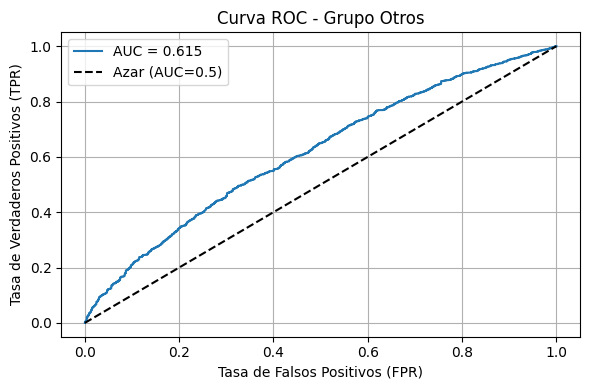

üìä Matriz de confusi√≥n:
 [[3605 2550]
 [2676 3493]]


In [26]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

# 1. Variables del grupo "otros"
other_cols = [
    'no_speech_prob', 'entropy',
    'tense_past', 'tense_present', 'tense_future',
    'sentiment_polarity', 'sentiment_subjectivity'
]

# 2. Preparar X e y
X_other = df[other_cols]
y = df["target"]

# 3. Normalizaci√≥n
scaler = StandardScaler()
X_other_scaled = scaler.fit_transform(X_other)

# 4. Crear DataFrame alineado con y
X_other_df = pd.DataFrame(X_other_scaled, columns=other_cols, index=y.index)
X_other_df = sm.add_constant(X_other_df)

# 5. Entrenar modelo logit
logit_model = sm.Logit(y, X_other_df).fit()
print(logit_model.summary())

# 6. Curva ROC
y_prob = logit_model.predict(X_other_df)
fpr, tpr, _ = roc_curve(y, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(y, y_prob):.3f}')
plt.plot([0, 1], [0, 1], 'k--', label='Azar (AUC=0.5)')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Grupo Otros')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. Matriz de confusi√≥n
print("üìä Matriz de confusi√≥n:\n", confusion_matrix(y, y_prob > 0.5))


In [27]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

# Extraer coeficientes, errores est√°ndar y p-valores
coef = logit_model.params
err = logit_model.bse
pval = logit_model.pvalues

# Intervalos de confianza al 95%
conf_int_low = coef - 1.96 * err
conf_int_high = coef + 1.96 * err

# Ordenar por magnitud
order = np.argsort(np.abs(coef))[::-1]

# Graficar
plt.figure(figsize=(10, 6))
for i, idx in enumerate(order):
    color = 'red' if pval[idx] < 0.05 else 'gray'
    plt.plot([conf_int_low[idx], conf_int_high[idx]], [i, i], 'k-', lw=1.5)
    plt.plot(coef[idx], i, 'o', color=color)

plt.yticks(range(len(coef)), coef.index[order])
plt.axvline(x=0, color='gray', linestyle='--')
plt.xlabel("Coeficiente (y IC 95%)")
plt.title("Coeficientes del modelo logit - Grupo Otros")
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Leyenda
legend_elements = [
    mpatches.Patch(color='red', label='Significativo (p < 0.05)'),
    mpatches.Patch(color='gray', label='No significativo')
]
plt.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.show()


üì¶ An√°lisis del grupo ‚ÄúOtros‚Äù
Este grupo incluye m√©tricas de estilo ling√º√≠stico, uso del lenguaje y se√±ales generales del contenido de voz.

üìà AUC = 0.615
Igual que el grupo de Voice Features (0.615).

Superior al azar (0.5), pero modesto por s√≠ solo.

Esto indica que algunos patrones en el contenido y estructura del habla pueden tener relaci√≥n con neurodivergencia, pero de forma d√©bil si se toman aislados.

üìã Variables significativas:
| Variable         | Coef.  | Interpretaci√≥n                                                                                  |
| ---------------- | ------ | ----------------------------------------------------------------------------------------------- |
| `no_speech_prob` | ‚Äì0.194 | A mayor probabilidad de no haber habla en el audio, **menor** probabilidad de neurodivergencia. |
| `entropy`        | ‚Äì0.251 | A menor entrop√≠a (m√°s estructura en el discurso), **mayor** probabilidad de neurodivergencia.   |
| `tense_past`     | ‚Äì0.290 | Uso del pasado reduce la probabilidad.                                                          |
| `tense_present`  | ‚Äì0.176 | Uso del presente tambi√©n la reduce.                                                             |
| `tense_future`   | ‚Äì0.202 | Hablar del futuro tambi√©n reduce probabilidad.                                                  |

---
### CON TEXTO AHORA:

üìã Clasificaci√≥n:
               precision    recall  f1-score   support

           0       0.85      0.90      0.87      1532
           1       0.89      0.84      0.87      1549

    accuracy                           0.87      3081
   macro avg       0.87      0.87      0.87      3081
weighted avg       0.87      0.87      0.87      3081

üß† AUC: 0.9444175219589155


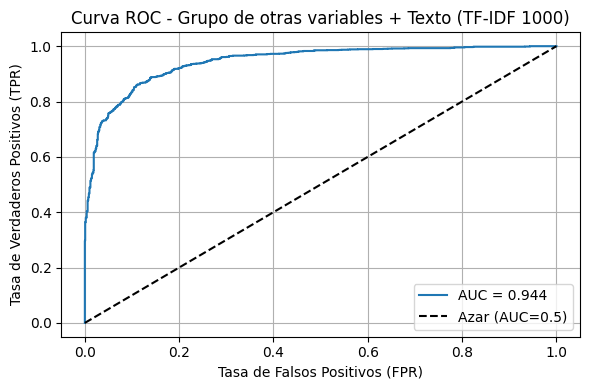

üìä Matriz de confusi√≥n:
 [[1373  159]
 [ 243 1306]]


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

# 1. Variables del grupo "otros"
other_cols = [
    'no_speech_prob', 'entropy',
    'tense_past', 'tense_present', 'tense_future',
    'sentiment_polarity', 'sentiment_subjectivity'
]

X_others = df[other_cols]
y = df["target"]

# 2. Normalizar faciales
scaler = StandardScaler()
X_others_scaled = scaler.fit_transform(X_others)

# 3. TF-IDF con 1000 palabras
tfidf = TfidfVectorizer(max_features=1000)
X_text_others = tfidf.fit_transform(df["translation"].fillna("")).toarray()

# 4. Concatenar facial + texto
X_combined = np.hstack([X_others_scaled, X_text_others])

# 5. Divisi√≥n train/test
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.25, random_state=42)

# 6. Entrenamiento con LogisticRegression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# 7. Predicci√≥n y evaluaci√≥n
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("üìã Clasificaci√≥n:\n", classification_report(y_test, y_pred))
print("üß† AUC:", roc_auc_score(y_test, y_prob))

# 8. Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0, 1], [0, 1], 'k--', label='Azar (AUC=0.5)')
plt.xlabel("Tasa de Falsos Positivos (FPR)")
plt.ylabel("Tasa de Verdaderos Positivos (TPR)")
plt.title("Curva ROC - Grupo de otras variables + Texto (TF-IDF 1000)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 9. Matriz de confusi√≥n
print("üìä Matriz de confusi√≥n:\n", confusion_matrix(y_test, y_pred))

____

## Comparativa de grupos: capacidad predictiva (Logit Models)

| Grupo                   | N¬∫ Variables | AUC   | Variables Significativas (`p < 0.05`) | Observaciones clave                                                                                          |
| ----------------------- | ------------ | ----- | ------------------------------------- | ------------------------------------------------------------------------------------------------------------ |
| **Facial**              | 7            | 0.568 | 6 de 7                                | Todas las emociones significativas (negativas), excepto sorpresa. Menor expresividad ‚Üí m√°s neurodivergencia. |
| **Personalidad**        | 12           | 0.663 | 7 de 12                               | `extraversion`, `conscientiousness`, y `openness` destacan. Grupo m√°s predictivo.                            |
| **Estado emocional**    | 12           | 0.644 | 5 de 12                               | `stress_medium`, `self_efficacy_high`, `depression_medium`... varios patrones complejos.                     |
| **Voice Features**      | 12           | 0.615 | 7 de 12                               | `voice_median`, `IQR`, `Q25`, `Q75`... tono y modulaci√≥n importantes.                                        |
| **Voice Emotions**      | 8            | 0.592 | 5 de 8                                | `sad_voice`, `neutral_voice`, `calm_voice`... emociones vocales √∫tiles, pero d√©biles solas.                  |
| **Otros (ling√º√≠stico)** | 7            | 0.615 | 5 de 7                                | `entropy`, `tense_*`, `no_speech_prob` significativos. Refleja estructura narrativa.                         |

---

## Conclusiones generales

1. **Grupo m√°s predictivo individualmente**: `üü¢ Personalidad` (AUC = 0.663)
2. **Grupos complementarios √∫tiles**: `Estado emocional`, `Voice Features`, y `Otros`
3. **Grupo menos informativo solo**: `Facial` (aunque con varias variables muy significativas)
4. **Muchas variables se solapan en l√≥gica**: baja entrop√≠a, menor expresividad, mayor autocontrol...

---

## Que hacer
Odds Ratios?